# Bike Sharing - Linear Regression

# PROBLEM STATEMENT UNDERSTANDING

<b>The given situation pertains to a business problem being faced by BoomBikes.</b>

The company has witnessed considerable dip in revenues during Covid induced lockdowns and suffered heavy losses and is struggling to survive.

The company wants to create a robust business plan and has roped in a consulting company to help it understand the demand patterns of bike sharing ones the lockdown opens. Specifically, they wish to `understand the factors on which the demand of these bikes depends`.

In a nutshell, deliverables by the consulting firm are:
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

# Importing Libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.5f' % x)


# 1: Loading and Basic Data Understanding

- #### 1.1: Loading Dataset

In [92]:
bike_df= pd.read_csv('day.csv')
bike_df.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        1           1   
1        2  02-01-2018       1   0     1        0        2           1   
2        3  03-01-2018       1   0     1        0        3           1   
3        4  04-01-2018       1   0     1        0        4           1   
4        5  05-01-2018       1   0     1        0        5           1   

   weathersit     temp    atemp      hum  windspeed  casual  registered   cnt  
0           2 14.11085 18.18125 80.58330   10.74988     331         654   985  
1           2 14.90260 17.68695 69.60870   16.65211     131         670   801  
2           1  8.05092  9.47025 43.72730   16.63670     120        1229  1349  
3           1  8.20000 10.60610 59.04350   10.73983     108        1454  1562  
4           1  9.30524 11.46350 43.69570   12.52230      82        1518  1600

- #### 1.2: Basic Observations and Data Understanding

In [93]:
print(f'Given dataset contains {bike_df.shape[0]} rows and {bike_df.shape[1]} columns.')

Given dataset contains 730 rows and 16 columns.


In [94]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [95]:
# Checking for duplicate values:
len(bike_df[bike_df.duplicated()])

0

No duplicate values found

<b> Observations: </b>
- Dataset contains 730 rows
- Dataset contains 15 columns
- **No null values are present in dataet. So, null value handling will not be done.**
- **No duplicat value found in Dataset.**

- ### 1.2.1: Feature Understanding


Following information about various columns has been extracted from data
dictionary. Columns further understanding is highlighted by the researcher
wherever an explanation is needed:

- instant: record index This column acts just as a serial number and is thus redundant. It will be dropped in next step.

- dteday : date Since purpose of this assignment is aimed at linear regression, and we have been given the day of the week, month, year, holiday data in seperate columns, we will drop this column in next step too

- season : season (1:spring, 2:summer, 3:fall, 4:winter) This feature will be converted to season names so that proper dummies can be created

- yr : year (0: 2018, 1:2019) his column signifies the year in boolean form as indicated.

- mnth : month ( 1 to 12) This feature will be converted to month names so that proper dummies can be created

- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule) This is a binary variable

- weekday : day of the week This feature will be converted to day names so that proper dummies can be created

- workingday : if day is neither weekend nor holiday is 1, otherwise is 0. This variable is an extract of holiday and weekday. During the course of assignment, post visualization, researcher will decide on transforming this column further if rquired.

- weathersit : Numeric values in this variable will be converted to below mentioned text entries. Post conversion, patterns will be visualized and dummy variables will be created before the model development
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy This will be converted to "Clear to Partly Cloudy"
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist This will be converted to "misty and cloudy"
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds This will be converted to "light rain and light snow"
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog This will be converted to "heavy rain and heavy snow"

- temp : temperature in Celsius

- atemp: feeling temperature in Celsius

- hum: humidity

- windspeed: wind speed

- casual: count of casual users Unregistered customers

- registered: count of registered users

- cnt: count of total rental bikes including both casual and registered This is the Target Variable. Since this column is sum of casual and registered, ideally we should drop both the variables. However, we will decide on dropping them at a later stage post visualization.


**Dropping features based on above shared logic**

In [96]:
# Creating variable to store list of feature names to be dropped
drop_col= ['instant', 'dteday']

# Creating a loop to drop the columns
for i in bike_df.columns:
    if i in drop_col:
        bike_df.drop(labels= i, axis= 1, inplace= True)

#Inspecting dataframe
bike_df.head(2)


season  yr  mnth  holiday  weekday  workingday  weathersit     temp  \
0       1   0     1        0        1           1           2 14.11085   
1       1   0     1        0        2           1           2 14.90260   

     atemp      hum  windspeed  casual  registered  cnt  
0 18.18125 80.58330   10.74988     331         654  985  
1 17.68695 69.60870   16.65211     131         670  801

<b> Basic Data Propriety Assesment</b>

In [97]:
bike_df.describe()

season        yr      mnth   holiday   weekday  workingday  \
count 730.00000 730.00000 730.00000 730.00000 730.00000   730.00000   
mean    2.49863   0.50000   6.52603   0.02877   2.99589     0.69041   
std     1.11018   0.50034   3.45022   0.16727   2.00034     0.46264   
min     1.00000   0.00000   1.00000   0.00000   0.00000     0.00000   
25%     2.00000   0.00000   4.00000   0.00000   1.00000     0.00000   
50%     3.00000   0.50000   7.00000   0.00000   3.00000     1.00000   
75%     3.00000   1.00000  10.00000   0.00000   5.00000     1.00000   
max     4.00000   1.00000  12.00000   1.00000   6.00000     1.00000   

       weathersit      temp     atemp       hum  windspeed     casual  \
count   730.00000 730.00000 730.00000 730.00000  730.00000  730.00000   
mean      1.39452  20.31926  23.72632  62.76517   12.76362  849.24932   
std       0.54481   7.50673   8.15031  14.23759    5.19584  686.47987   
min       1.00000   2.42435   3.95348   0.00000    1.50024    2.00000   
25%       1.00000  13.81189  16.88971  52.00000    9.04165  316.25000   
50%       1.00000  20.46583  24.36822  62.62500   12.12533  717.00000   
75%       2.00000  26.88061  30.44577  72.98958   15.62559 1096.50000   
max       3.00000  35.32835  42.04480  97.25000   34.00002 3410.00000   

       registered        cnt  
count   730.00000  730.00000  
mean   3658.75753 4508.00685  
std    1559.75873 1936.01165  
min      20.00000   22.00000  
25%    2502.25000 3169.75000  
50%    3664.50000 4548.50000  
75%    4783.25000 5966.00000  
max    6946.00000 8714.00000

<b>Observations:</b>

- <b>season</b>: Season column has 4 values depicting each of the 4 seasons. No deviation found.
- <b>yr</b>: Data comprises of exactly 2 years
- <b>mnth</b>: Number of months is exactly 12 hence no abnormalities noticed.
- <b>holiday</b>: Max is 1 and Min is 0. No deviation in this bollean column
- <b>weekday</b>: Weekdays are depicted as exactly 7 (0 to 6) corresponding to each day name. On checking data, it was noticed that the numeric values start from 0 on Sunday.
- <b>weathersit</b>: As per data dictionary, we are supposed to have 4 weather situations whereas the data does not contain 4th weather. The values corerspond to weather situation 1 OR 2 OR 3 only.
- <b>temp</b>: Variance of temperature is between 2.4 and 35.3 with median value of 20.5. This is indicative of tropical climate in the region as per Wikipedia Article that places mean temperature of tropical regions at around 18+ degree celsius: https://en.wikipedia.org/wiki/Tropical_climate This could, to a certain extent, possibly explain the absence of fourth season.
- <b>hum</b>: Humidity levels Q1 and Q3 are 50% + showing a relatively humid weather.
- <b>windpeed</b>: Windspeed doesnt show a heavy variance. Relatively calmer winds.
- <b>casual</b>: Relatively high variance as compared to 'registered'.
- <b>registered</b>: With given numbers, it seems to be more in line with the trend on target variable (cnt).


<b> Transforming season, weathersit, mnth and weekday columns based on above logic</b>

In [98]:

# Transforming weathersit feature:

bike_df['weathersit']= bike_df['weathersit'].map({1: 'Clear to Partly Cloudy',
                                                      2: 'Misty and Cloudy',
                                                      3: 'Light Rain or Snow',
                                                      4: 'Heavy Rain or Snow'})


# Transforming season feature:

bike_df['season']= bike_df['season'].map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})


# Mapping Month feature:

bike_df['mnth']= bike_df['mnth'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                      7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})


# Mapping Weekday feature:

bike_df['weekday']= bike_df['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})


# Re - Observing The dataset

bike_df.head()


season  yr mnth  holiday weekday  workingday              weathersit  \
0  Spring   0  Jan        0     Mon           1        Misty and Cloudy   
1  Spring   0  Jan        0     Tue           1        Misty and Cloudy   
2  Spring   0  Jan        0     Wed           1  Clear to Partly Cloudy   
3  Spring   0  Jan        0     Thu           1  Clear to Partly Cloudy   
4  Spring   0  Jan        0     Fri           1  Clear to Partly Cloudy   

      temp    atemp      hum  windspeed  casual  registered   cnt  
0 14.11085 18.18125 80.58330   10.74988     331         654   985  
1 14.90260 17.68695 69.60870   16.65211     131         670   801  
2  8.05092  9.47025 43.72730   16.63670     120        1229  1349  
3  8.20000 10.60610 59.04350   10.73983     108        1454  1562  
4  9.30524 11.46350 43.69570   12.52230      82        1518  1600

# 2: Exploratory Data Analysis

## 2.1: Univariate Analysis

- ### 2.1.1: Target Variable

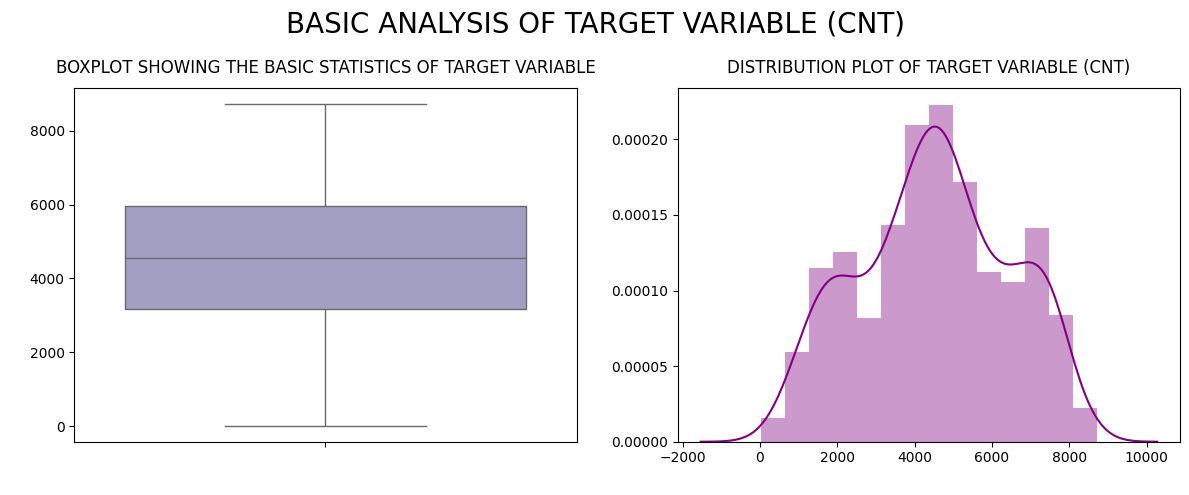

In [99]:

# Creating subplot grid:
fig, ax= plt.subplots(nrows= 1, ncols= 2, figsize= (12, 5))

# Creating main title
fig.suptitle('basic analysis of target variable (cnt)'.upper(), fontsize= 20)

# Populating plot1:
sns.boxplot(y=bike_df['cnt'], ax= ax[0], palette= 'Purples')
ax[0].set_title('boxplot showing the basic statistics of target variable'.upper(),
                fontsize= 12, fontweight= 20, y= 1.02)
ax[0].set_ylabel(' ')
ax[0].set_xlabel(' ')

# Populating plot2:
sns.distplot(bike_df['cnt'], ax= ax[1], color= 'purple')
ax[1].set_title('distribution plot of target variable (cnt)'.upper(),
                fontsize= 12, fontweight= 20, y= 1.02)
ax[1].set_ylabel(' ')
ax[1].set_xlabel(' ')

# Setting aesthetics
plt.tight_layout()
plt.show()


<b>Observations:</b>
- Target variable shows an almost normal distribution of values with 2 distinct plateaus on either side.
- Q1 of target variable lies at around 3000 and Q3 at around 6000. IQR thus is approximately 3000 with median at around 4500 value


- ### 2.1.2: Continuous Independent Variables

In [100]:
# Creating a list of continuous independent variables for analysis
cont_var= [i for i in bike_df.select_dtypes(exclude= 'object').columns if bike_df[i].nunique() > 2 and i != 'cnt']
print(cont_var)

['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']


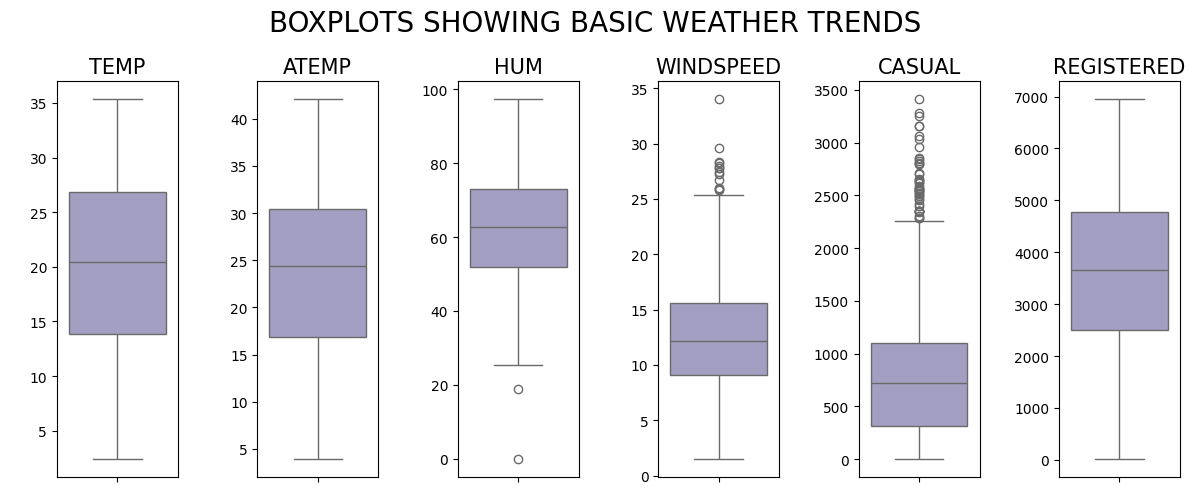

In [101]:
# BOXPLOT Representation
# Creating a subplot grid
fig, ax= plt.subplots(nrows= 1, ncols= len(cont_var), figsize= (12, 5))

# Placing main title
plt.suptitle('boxplots showing basic weather trends'.upper(), fontsize= 20)

# Looping to fill subplot grid with plots
for i in range(len(cont_var)):

    sns.boxplot(y=bike_df[cont_var[i]], ax= ax[i], palette= 'Purples')

    # Setting aesthetics and readability
    ax[i].set_title(f'{cont_var[i].upper()}', fontsize= 15)
    ax[i].set_ylabel(' ')

# Setting final aesthetics
plt.tight_layout()
plt.show()


<b>Observations:</b>
- Q1 and Q3 of temp is distributed between 14 and 27 with median as 21.
- Q1 and Q3 of atemp is distributed between 17 and 31 with median as 24.
- Humidity and windspeed have shown presence of outliers and casual too.
- Temp and Atemp appear to be almost normally distributed.

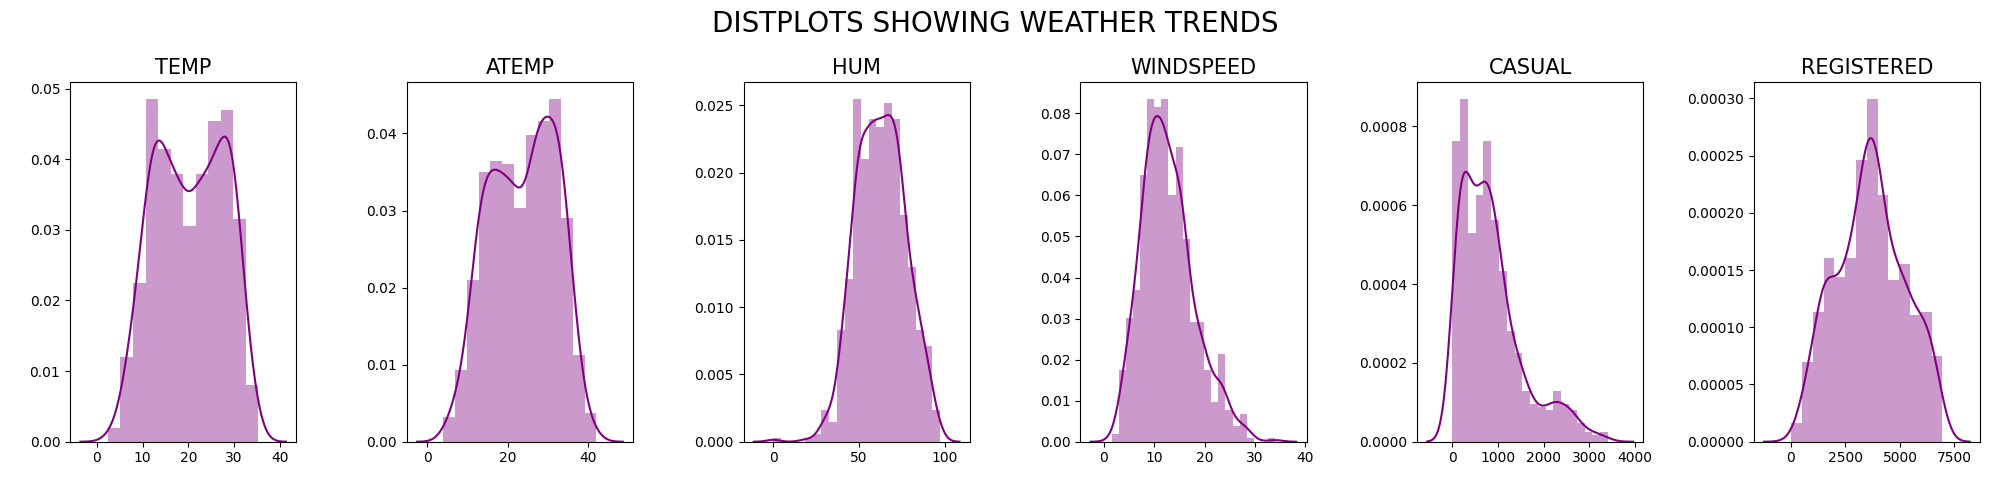

In [102]:
# DISPLOT Representation
# Creating a subplot grid
fig, ax= plt.subplots(nrows= 1, ncols= len(cont_var), figsize= (20, 5))

# Placing main title
plt.suptitle('distplots showing weather trends'.upper(), fontsize= 20)

# Looping to fill subplot grid with plots
for i in range(len(cont_var)):

    sns.distplot(bike_df[cont_var[i]], ax= ax[i], color= 'purple')

    # Setting aesthetics and readability
    ax[i].set_title(f'{cont_var[i].upper()}', fontsize= 15)
    ax[i].set_ylabel(' ')
    ax[i].set_xlabel(' ')

# Setting final aesthetics
plt.tight_layout()
plt.show()


<b>Observations:</b>
- Above distplot prove our earlier intuitive understanding of variables as incorrect - Temp and atemp have shown double peaks.
- Humidity and Windspeed are left and right skewed respectively.
- Casual shows high right skew.
- Registered shows similar trend as target variable but plateaus on either side are relatively smoother.

- ### 2.1.3: Categorical Independent Variables

In [103]:
# Creating a list of categorical independent variables for analysis
cat_var= [i for i in bike_df.select_dtypes(include= 'object').columns]
cat_var.extend([i for i in bike_df.columns if bike_df[i].nunique() == 2])
print(cat_var)

['season', 'mnth', 'weekday', 'weathersit', 'yr', 'holiday', 'workingday']


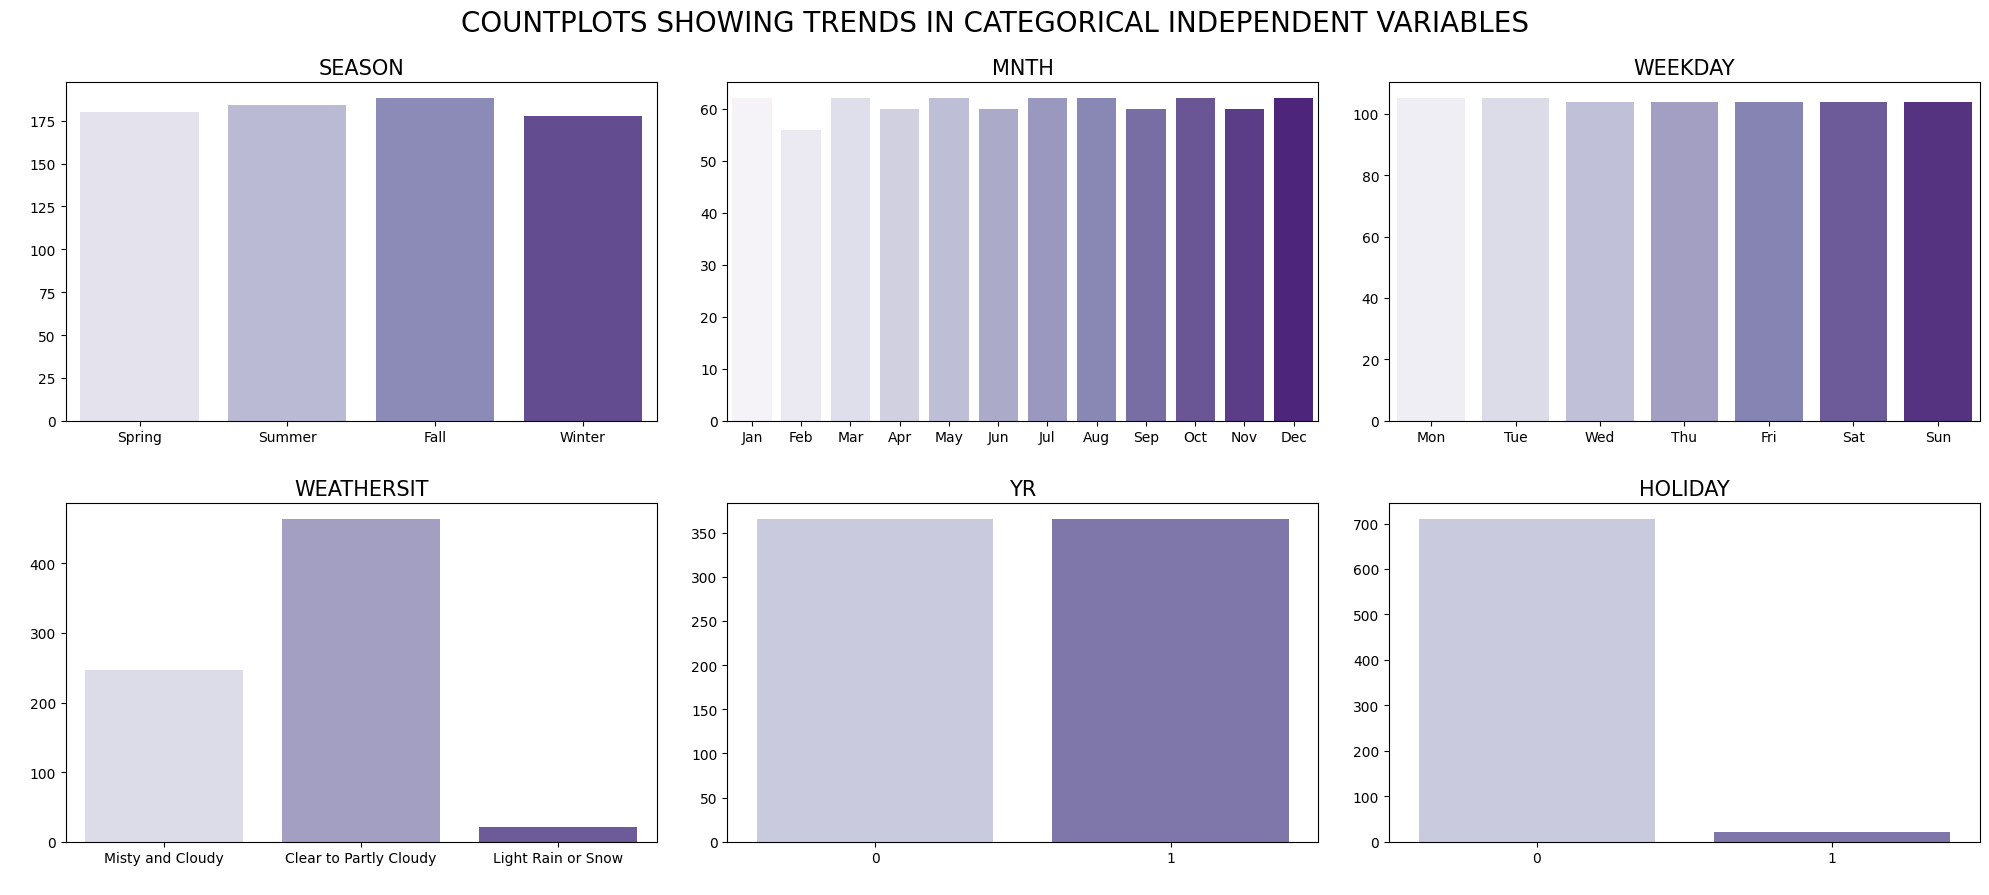

In [104]:
# BOXPLOT Representation
# Creating a subplot grid
fig, ax= plt.subplots(nrows= 2, ncols= int(len(cont_var)/2), figsize= (20, 9))

# Placing main title
plt.suptitle('countplots showing trends in categorical independent variables'.upper(), fontsize= 20, fontweight= 20, y= 0.99)

# Looping to fill subplot grid with plots
k= 0
for i in range(2):
    for j in range(int(len(cat_var)/2)):
        sns.countplot(x=bike_df[cat_var[k]], ax= ax[i, j], palette= 'Purples',
                      )  # Set y= for horizontal bars

        # Setting aesthetics and readability
        ax[i,j].set_title(f'{cat_var[k].upper()}', fontsize= 15)
        ax[i,j].set_ylabel(' ')
        ax[i,j].set_xlabel(' ')

        k+=1

# Setting final aesthetics
plt.tight_layout()
plt.show()

<b>Observations:</b>
- Fall is found to be the longest season, followed by summer, followed by Spring. Shortest season is winter.
- Weathersit shows just 3 types of weathers. There is not even a single day on which Heavy rain/ snow has occured. Weather has been clear OR partly cloudy for most of the days in both years.
- The peculier combination of Season and Weathersit also shows the location of the city in dataset is in tropical region with limited rainfall and is akin to the weather of one of the west coastal cities of US somewhere in California (Ex: Los Angeles/ San Francisco etc). This statement is further supported by the observed data of humidity, temp and atemp.

- ## 2.2: Bivariate Analysis

- ### 2.2.1: Continuous Independent Variables

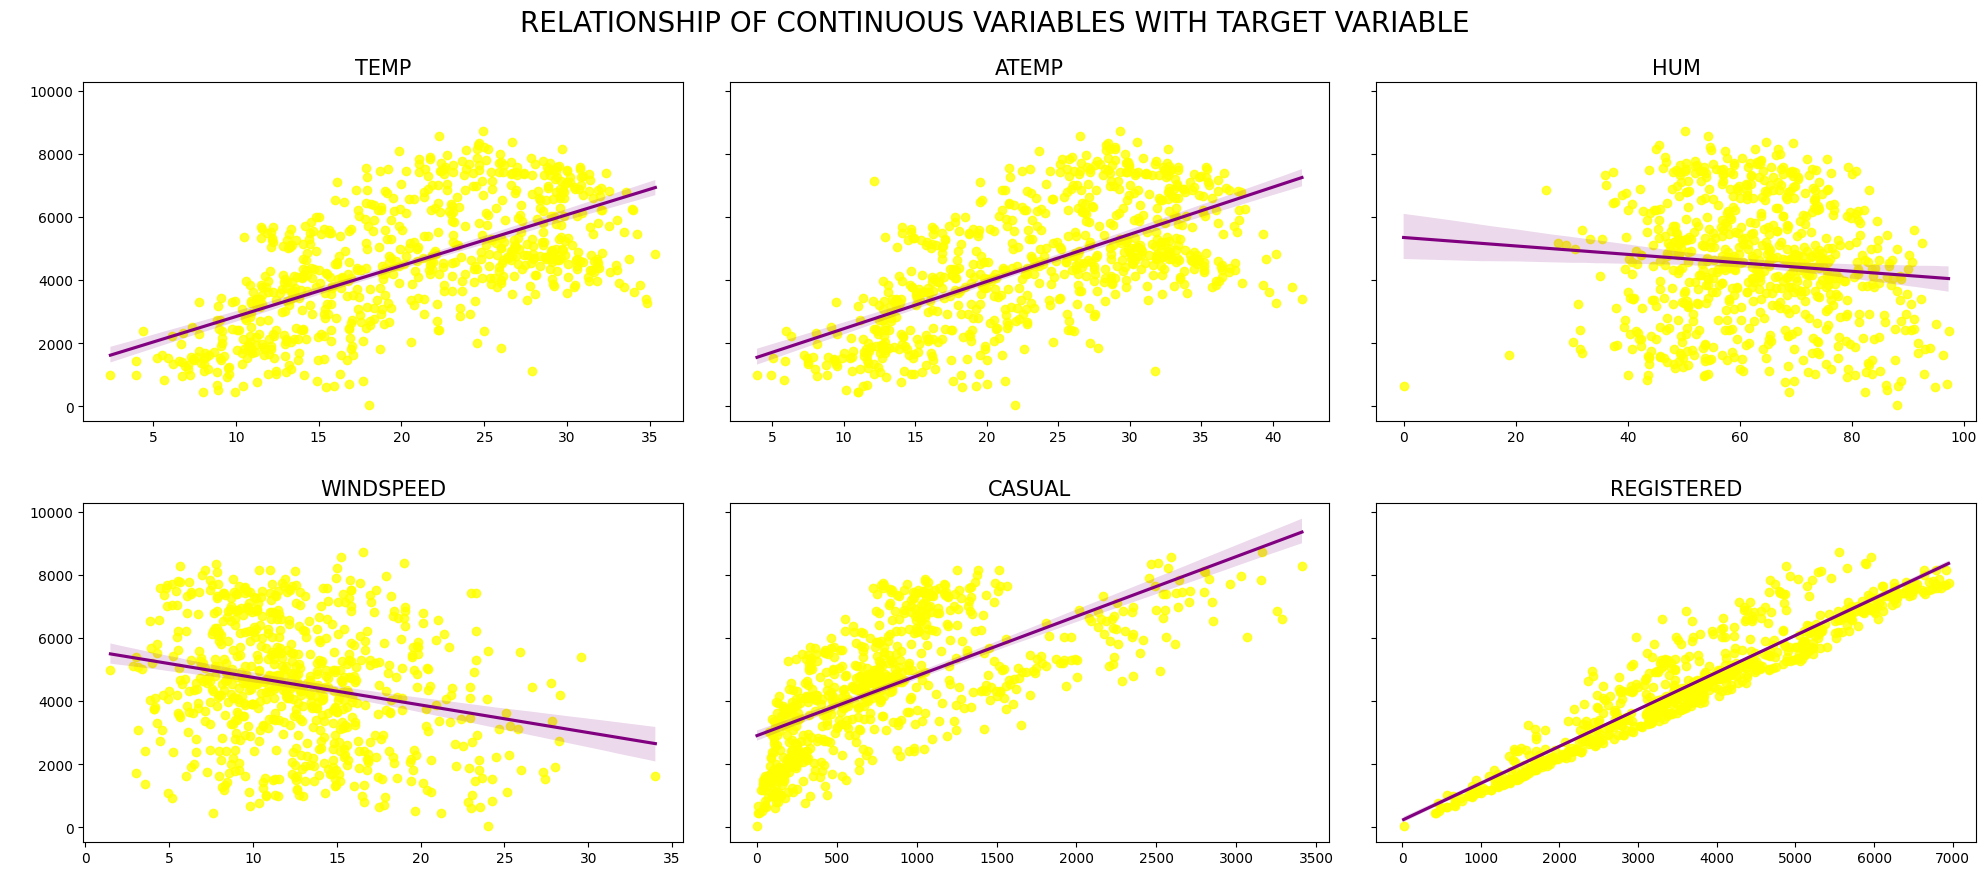

In [105]:

# Creating a subplot grid
fig, ax= plt.subplots(nrows= 2, ncols= int(len(cont_var)/2), figsize= (20, 9), sharey= True)

# Placing main title
plt.suptitle('relationship of continuous variables with target variable'.upper(), fontsize= 20, fontweight= 20, y= 0.99)

# Looping to fill subplot grid with plots
k= 0
for i in range(2):
    for j in range(int(len(cont_var)/2)):
        sns.regplot(x= bike_df[cont_var[k]], y=bike_df['cnt'], ax= ax[i, j],
                    scatter_kws= {'color': 'yellow'}, line_kws= {'color': 'purple'})

        # Setting aesthetics and readability
        ax[i,j].set_title(f'{cont_var[k].upper()}', fontsize= 15)
        ax[i,j].set_ylabel(' ')
        ax[i,j].set_xlabel(' ')

        k+=1

# Setting final aesthetics
plt.tight_layout()
plt.show()


<b>Observations:</b>
- Bike demand shows a similar and directly proportional relationship with temp and atemp
- Bike demand shows inverse proportionality with Humidity and Windspeed.
- Bike demand is directly proportional to Casual and Registered numbers.
- Bike demand is very well explained by the registered users.

- ### 2.2.2: Categorical Independent Variables

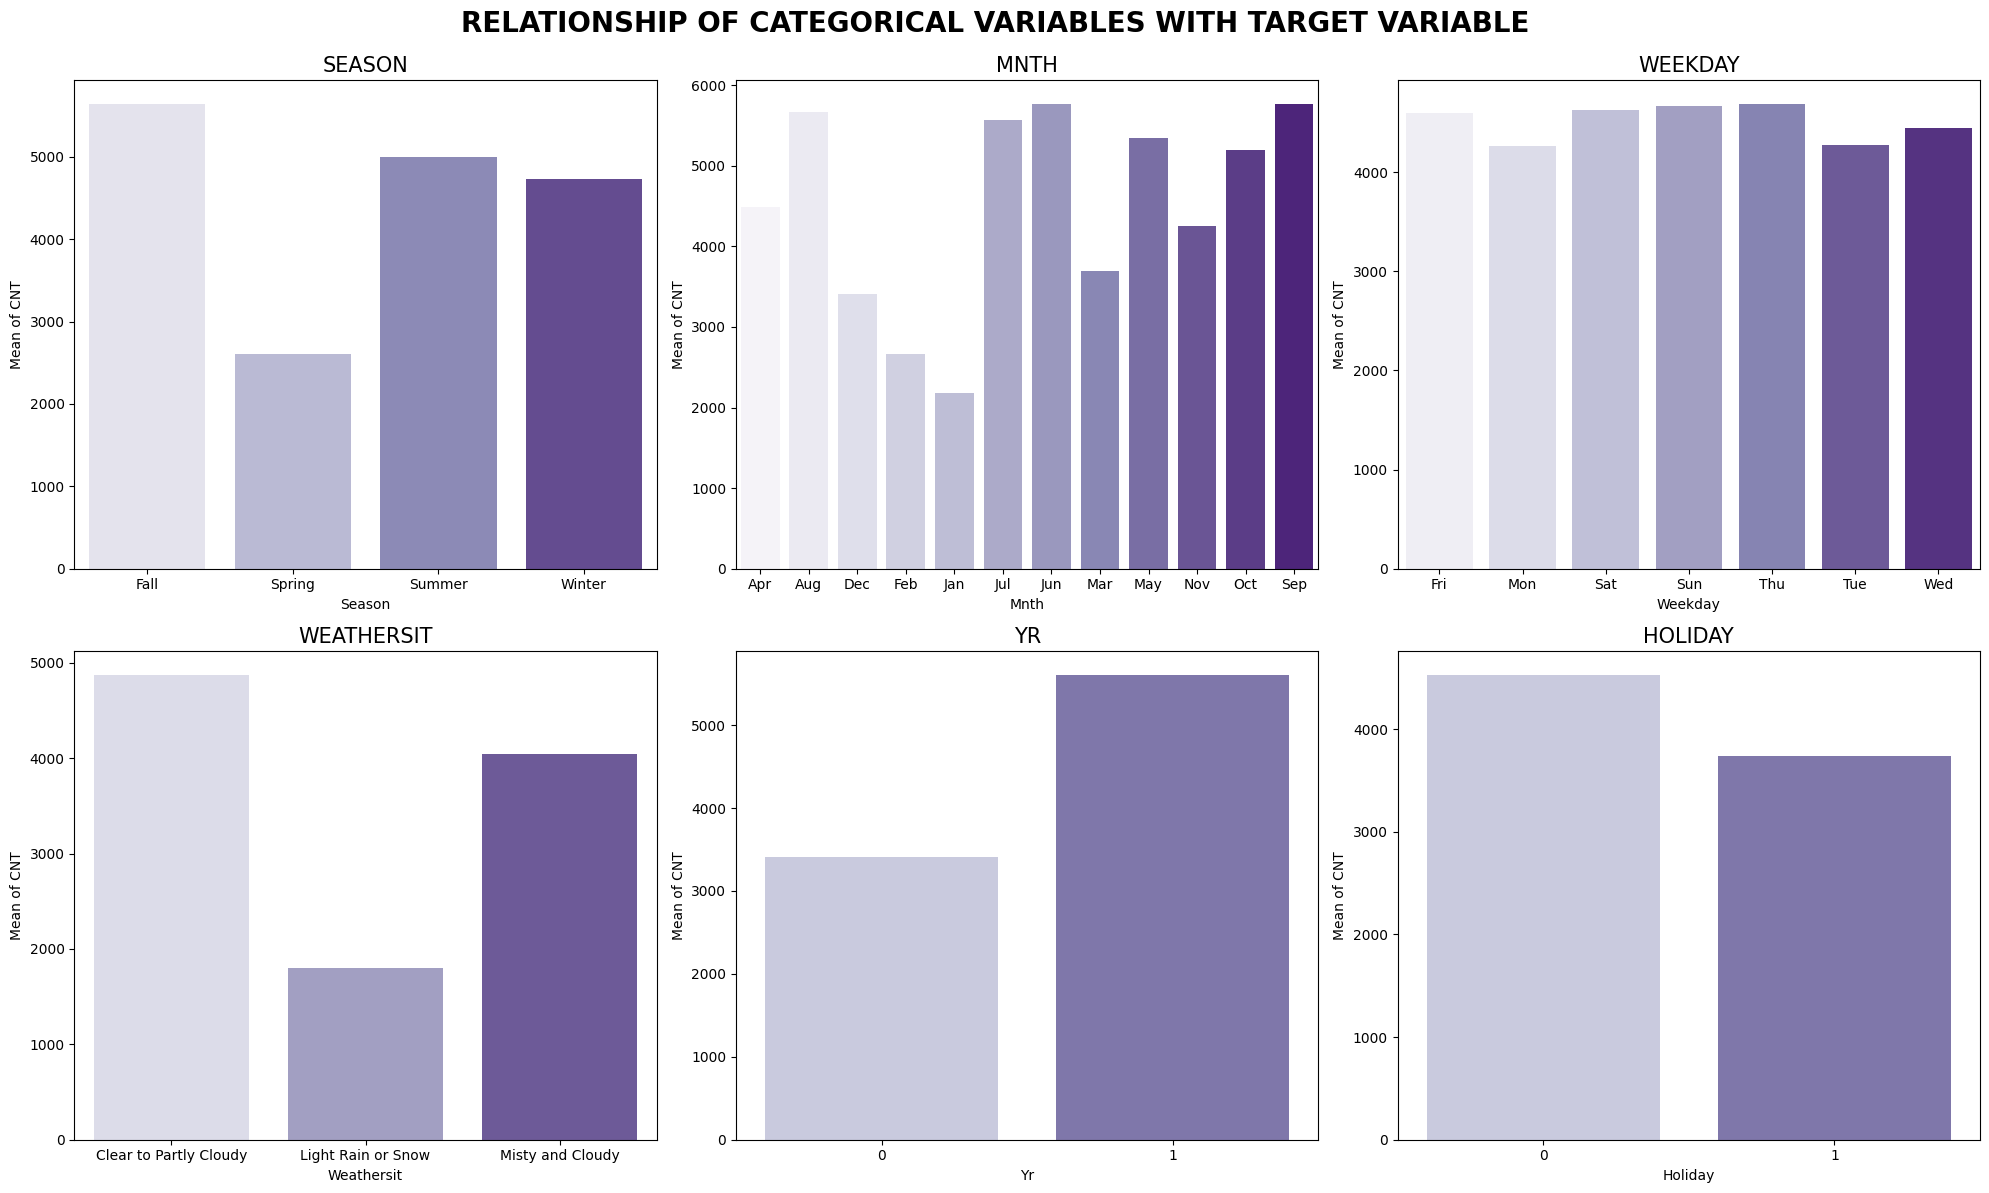

In [106]:
# Create subplot grid
fig, ax = plt.subplots(nrows=2, ncols=int(len(cat_var)/2), figsize=(20, 12))

# Place main title
plt.suptitle('RELATIONSHIP OF CATEGORICAL VARIABLES WITH TARGET VARIABLE', fontsize=20, fontweight='bold', y=0.99)

k = 0
for i in range(2):
    for j in range(int(len(cat_var)/2)):
        if k < len(cat_var):
            # Calculate mean of 'cnt' for each group defined by cat_var[k]
            mean_values = bike_df.groupby(cat_var[k])['cnt'].mean()

            # Plotting
            sns.barplot(
                y=mean_values,
                x=mean_values.index,
                ax=ax[i, j],
                palette='Purples'
            )

            # Setting aesthetics
            ax[i, j].set_title(f'{cat_var[k].upper()}', fontsize=15)
            ax[i, j].set_ylabel('Mean of CNT')
            ax[i, j].set_xlabel(cat_var[k].capitalize())

            k += 1
        else:
            ax[i, j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

<b>Observations:</b>
- Maximum demand noticed in Fall Season followed by Summer and Winter. Spring season shows a steep decrease in demand.
- Months of Aug, Jun and Sep display highest demand trend followed by the months of Jul, May and Oct. `This effectively defines a six month period from May till October that can be classified as high demand period. Months seem to show a drastic imapct on business.`
- Highest demand traction observed on Friday, Saturday, Sunday and Thursday. `This effectively shows that the usage of bikes have been for mixed use (For office as well as leisure travel)`
- Demand is exceptionally high on clear days
- Company has shown significant business increase from 2018 to 2019
- Usage of cycle on holidays is slightly lower then weekdays
- Usage is almost similar irrespective of being a working day or not.

<b>Demand comaprison on Working Day and Non Working Day</b>

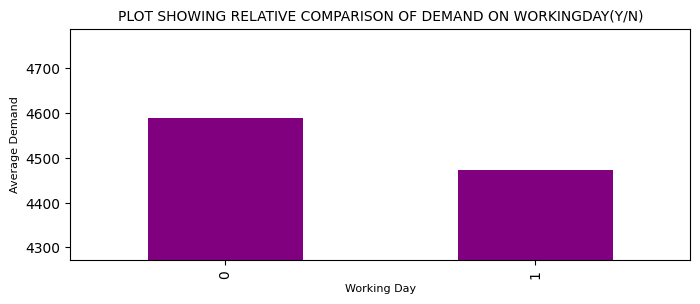

In [107]:
workday_cnt = bike_df.groupby('workingday')['cnt'].mean()
plt.figure(figsize= (8, 3))
plt.title('plot showing relative comparison of demand on workingday(y/n)'.upper(), fontsize= 10)
workday_cnt.plot.bar(color= 'purple')
plt.ylabel('average demand'.title(), fontsize= 8)
plt.xlabel('working day'.title(), fontsize= 8)
plt.ylim(min(workday_cnt)-200,
         max(workday_cnt)+200)
plt.show()

<b>Observations:</b>
- Usage is found to be higher on non-working days.
- Since the demand-fall on weekdays is limited to close to 3%, the demand gap is minimal.
- Recall our previous visualization that highlights the reason for this - More number of sluggish demand days during weekdays are pulling this average down whereas robust demand on all days of weekends pull the average demand higher.

- ### 2.2.3: Seasonwise variation in weather related continuous variables

In [108]:

# Initializing feature list for weather related continuous variables:
weather_var= ['temp', 'atemp', 'hum', 'windspeed']


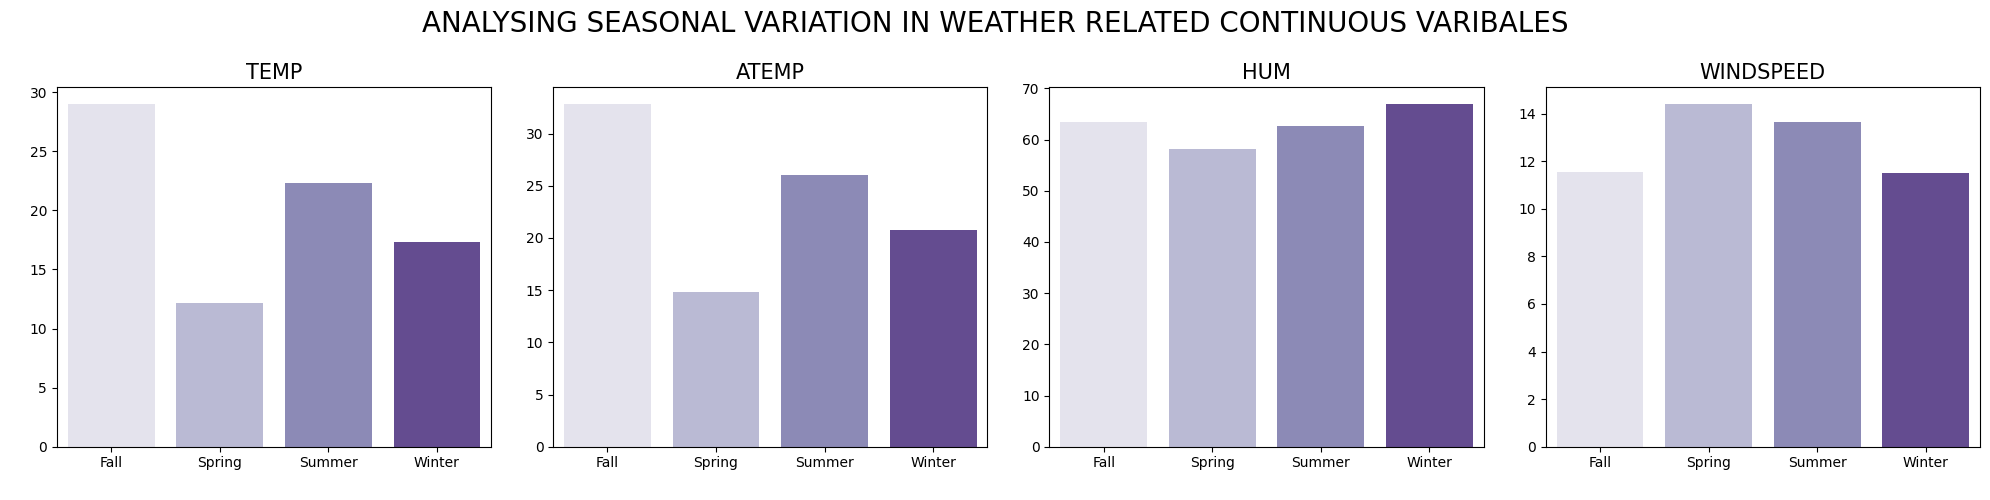

In [109]:

# Creating a subplot grid
fig, ax= plt.subplots(nrows= 1, ncols= len(weather_var), figsize= (20, 5))

# Placing main title
plt.suptitle('analysing seasonal variation in weather related continuous varibales'.upper(), fontsize= 20, fontweight= 15, y= 0.99)

# Looping to fill subplot grid with plots
for i in range(len(weather_var)):
    weather_mean =bike_df.groupby('season')[weather_var[i]].mean()
    sns.barplot(y= weather_mean,
               x= weather_mean.index, ax= ax[i], palette= 'Purples')


    # Setting aesthetics and readability
    ax[i].set_title(f'{weather_var[i].upper()}', fontsize= 15)
    ax[i].set_ylabel(' ')
    ax[i].set_xlabel(' ')

# Setting final aesthetics
plt.tight_layout()
plt.show()


<b>Observations:</b>
- Weather variables have shown an unusual pattern wherein the average temperature and average temperature feeling is found to be highest in fall season followed by summer season.
- Instead of winter, spring shows relatively lower average temperature and average temperature feeling.
- Humidity is found to be highest in winter season followed by fall, summer and spring.
- Windspeed is found to be highest in spring, followed by summer.

<b>Below is a reference table that shows seasonwise and monthwise variation of continuous weather features</b>

In [110]:
numeric_cols = ['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
bike_df[numeric_cols] = bike_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Group by 'season' and 'mnth' and calculate the mean
bike_df.groupby(['season', 'mnth'])[numeric_cols].mean()



yr  holiday  workingday     temp    atemp      hum  \
season mnth                                                           
Fall   Aug  0.50000  0.00000     0.72581 29.05184 32.57374 63.77301   
       Jul  0.50000  0.03226     0.69355 30.97429 35.20469 59.78763   
       Jun  0.50000  0.00000     0.65000 29.81554 33.56743 54.40625   
       Sep  0.50000  0.04545     0.63636 25.59775 29.35985 71.83132   
Spring Dec  0.50000  0.09091     0.54545 12.21599 14.72987 63.84248   
       Feb  0.50000  0.03571     0.67857 12.23525 14.94305 56.32269   
       Jan  0.50000  0.04839     0.69355  9.69420 11.98979 58.58283   
       Mar  0.50000  0.00000     0.70000 16.01250 19.13531 56.98311   
Summer Apr  0.50000  0.03333     0.70000 19.26995 22.85404 58.80631   
       Jun  0.50000  0.00000     0.70000 27.16421 31.08471 59.16770   
       Mar  0.50000  0.00000     0.68182 16.01134 19.02927 62.23732   
       May  0.50000  0.03226     0.70968 24.38674 28.28310 68.89583   
Winter Dec  0.50000  0.00000     0.72500 13.87337 17.17595 68.12292   
       Nov  0.50000  0.06667     0.68333 15.13801 18.36794 62.48765   
       Oct  0.50000  0.03226     0.70968 19.88550 23.59866 69.37609   
       Sep  0.50000  0.00000     0.68750 24.39074 27.87898 70.48177   

             windspeed     casual  registered        cnt  
season mnth                                               
Fall   Aug    11.58552 1161.91935  4502.50000 5664.41935  
       Jul    11.12594 1260.59677  4303.08065 5563.67742  
       Jun    12.90432 1188.05000  4581.35000 5769.40000  
       Sep    11.39800 1184.86364  4487.84091 5672.70455  
Spring Dec    14.30449  293.77273  1660.68182 1954.45455  
       Feb    14.49457  266.03571  2403.92857 2669.96429  
       Jan    13.82229  194.22581  1982.11290 2176.33871  
       Mar    15.15784  678.85000  2872.77500 3551.62500  
Summer Apr    15.71031 1013.36667  3471.53333 4484.90000  
       Jun    12.18254 1253.62500  4520.22500 5773.85000  
       Mar    14.48999  785.90909  3162.04545 3947.95455  
       May    12.26026 1214.27419  4135.50000 5349.77419  
Winter Dec    10.47337  380.75000  3820.20000 4200.95000  
       Nov    12.31470  610.05000  3637.13333 4247.18333  
       Oct    11.73877  963.87097  4235.35484 5199.22581  
       Sep    10.34921 1136.81250  4887.68750 6024.50000

- ### 2.2.4: Weathersitwise variation in weather related continuous variables

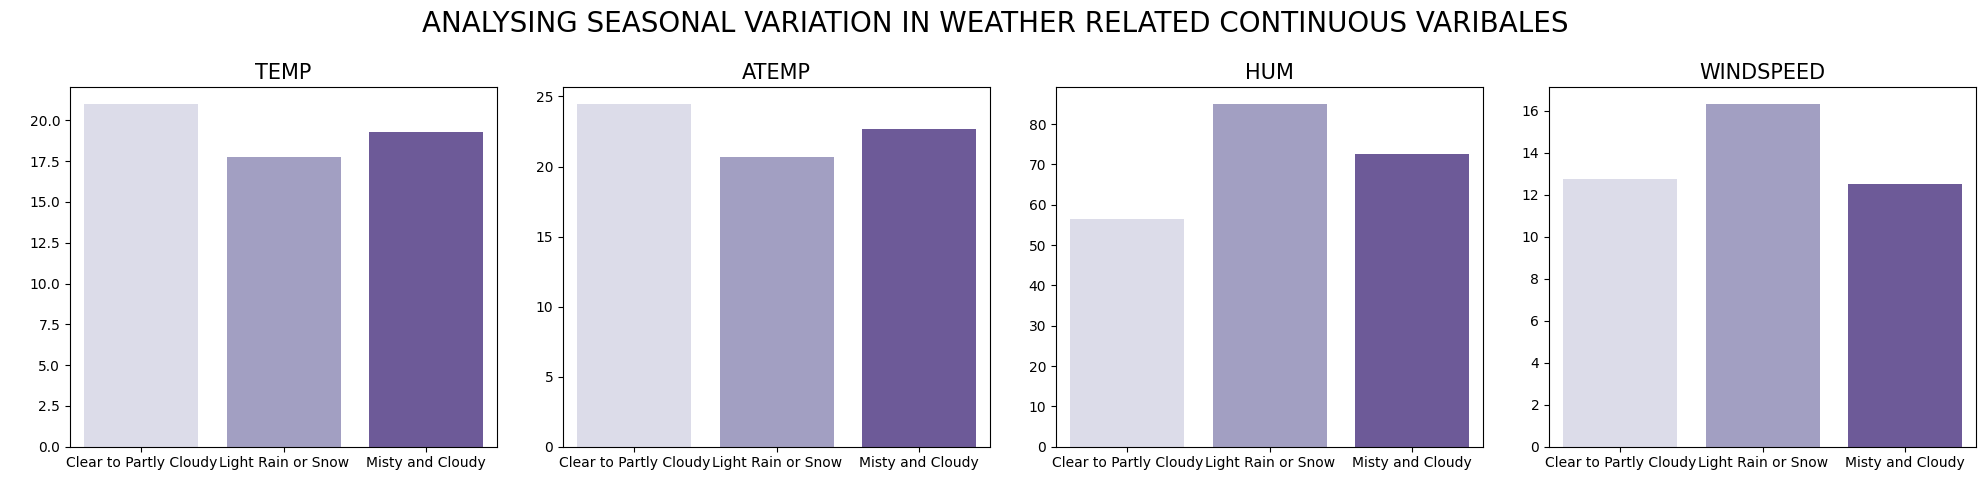

In [111]:

# Creating a subplot grid
fig, ax= plt.subplots(nrows= 1, ncols= len(weather_var), figsize= (20, 5))

# Placing main title
plt.suptitle('analysing seasonal variation in weather related continuous varibales'.upper(), fontsize= 20, fontweight= 15, y= 0.99)

# Looping to fill subplot grid with plots
for i in range(len(weather_var)):
    mean_weather = bike_df.groupby('weathersit')[weather_var[i]].mean()
    sns.barplot(y= mean_weather,
               x= mean_weather.index, ax= ax[i], palette= 'Purples')


    # Setting aesthetics and readability
    ax[i].set_title(f'{weather_var[i].upper()}', fontsize= 15)
    ax[i].set_ylabel(' ')
    ax[i].set_xlabel(' ')

# Setting final aesthetics
plt.tight_layout()
plt.show()


<b>Observations:</b>
- Temp and Atemp show highest mean values when the skies are clear to partly cloudy followed by misty weather followed by Light rains.
- Humidity is found to have highest mean values during light rains followed by misty weather followed by clear skies.
- Windspeed has highest mean values during light rains.


- ### 2.2.5: Monthwise variation in weathersit

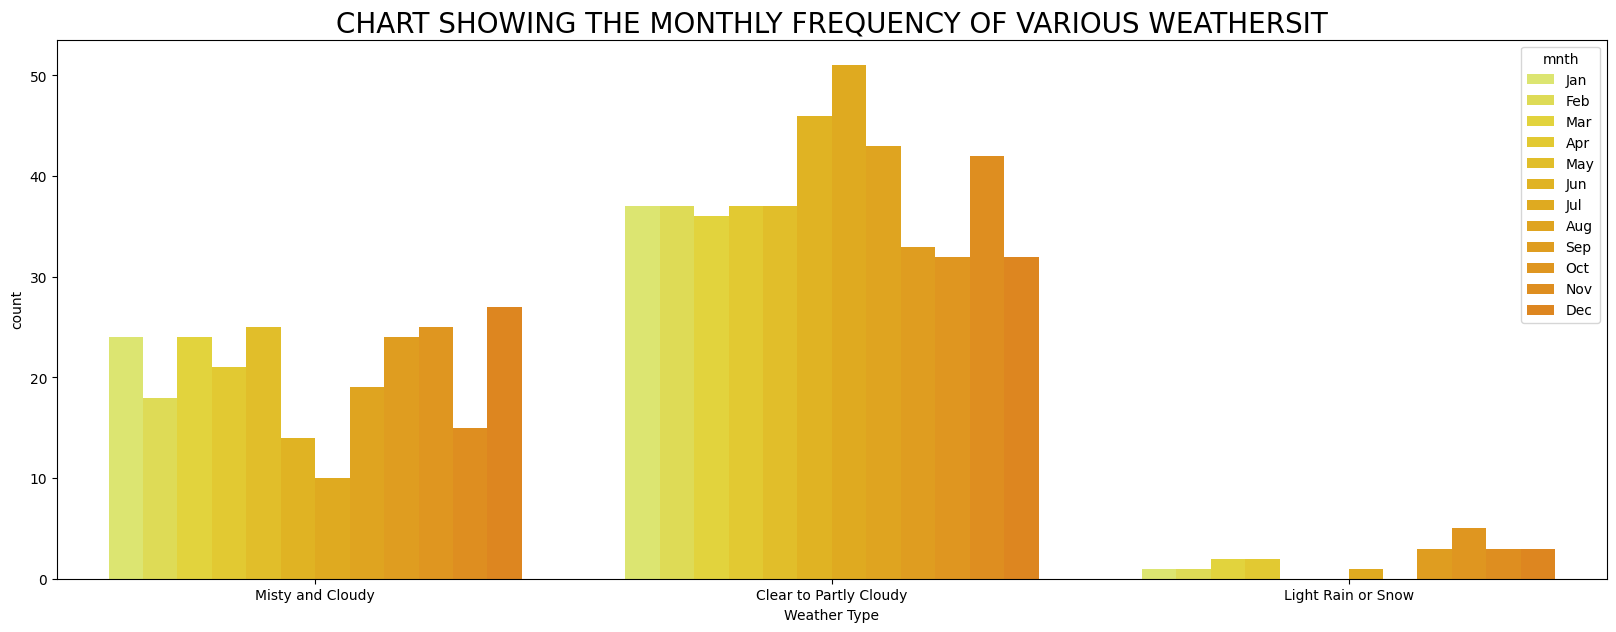

In [112]:
# Defining Figure size
plt.figure(figsize= (20, 7))

# Plotting
sns.countplot(x=bike_df['weathersit'], data= bike_df, hue= 'mnth', palette= 'Wistia')

# Adjusting labels and title
plt.title('chart showing the monthly frequency of various weathersit'.upper(), fontsize= 20)
plt.xlabel('weather type'.title())

plt.show()

<b>Observations:</b>
- Overall, maximum number of days have been 'Clear to Partly Cloudy' followed by 'Misty and Cloudy'.
- July has shown the maximum occurance of clear to aprtly cloudy days followed by Jun and then Aug.
- Maximum number of musty occurances have been observed in the month of December followed by Jan, Mar, May and Oct.

- ## 2.3: Intervariable Relationships

- ### 2.3.1: Intervariable relationships using pairplot

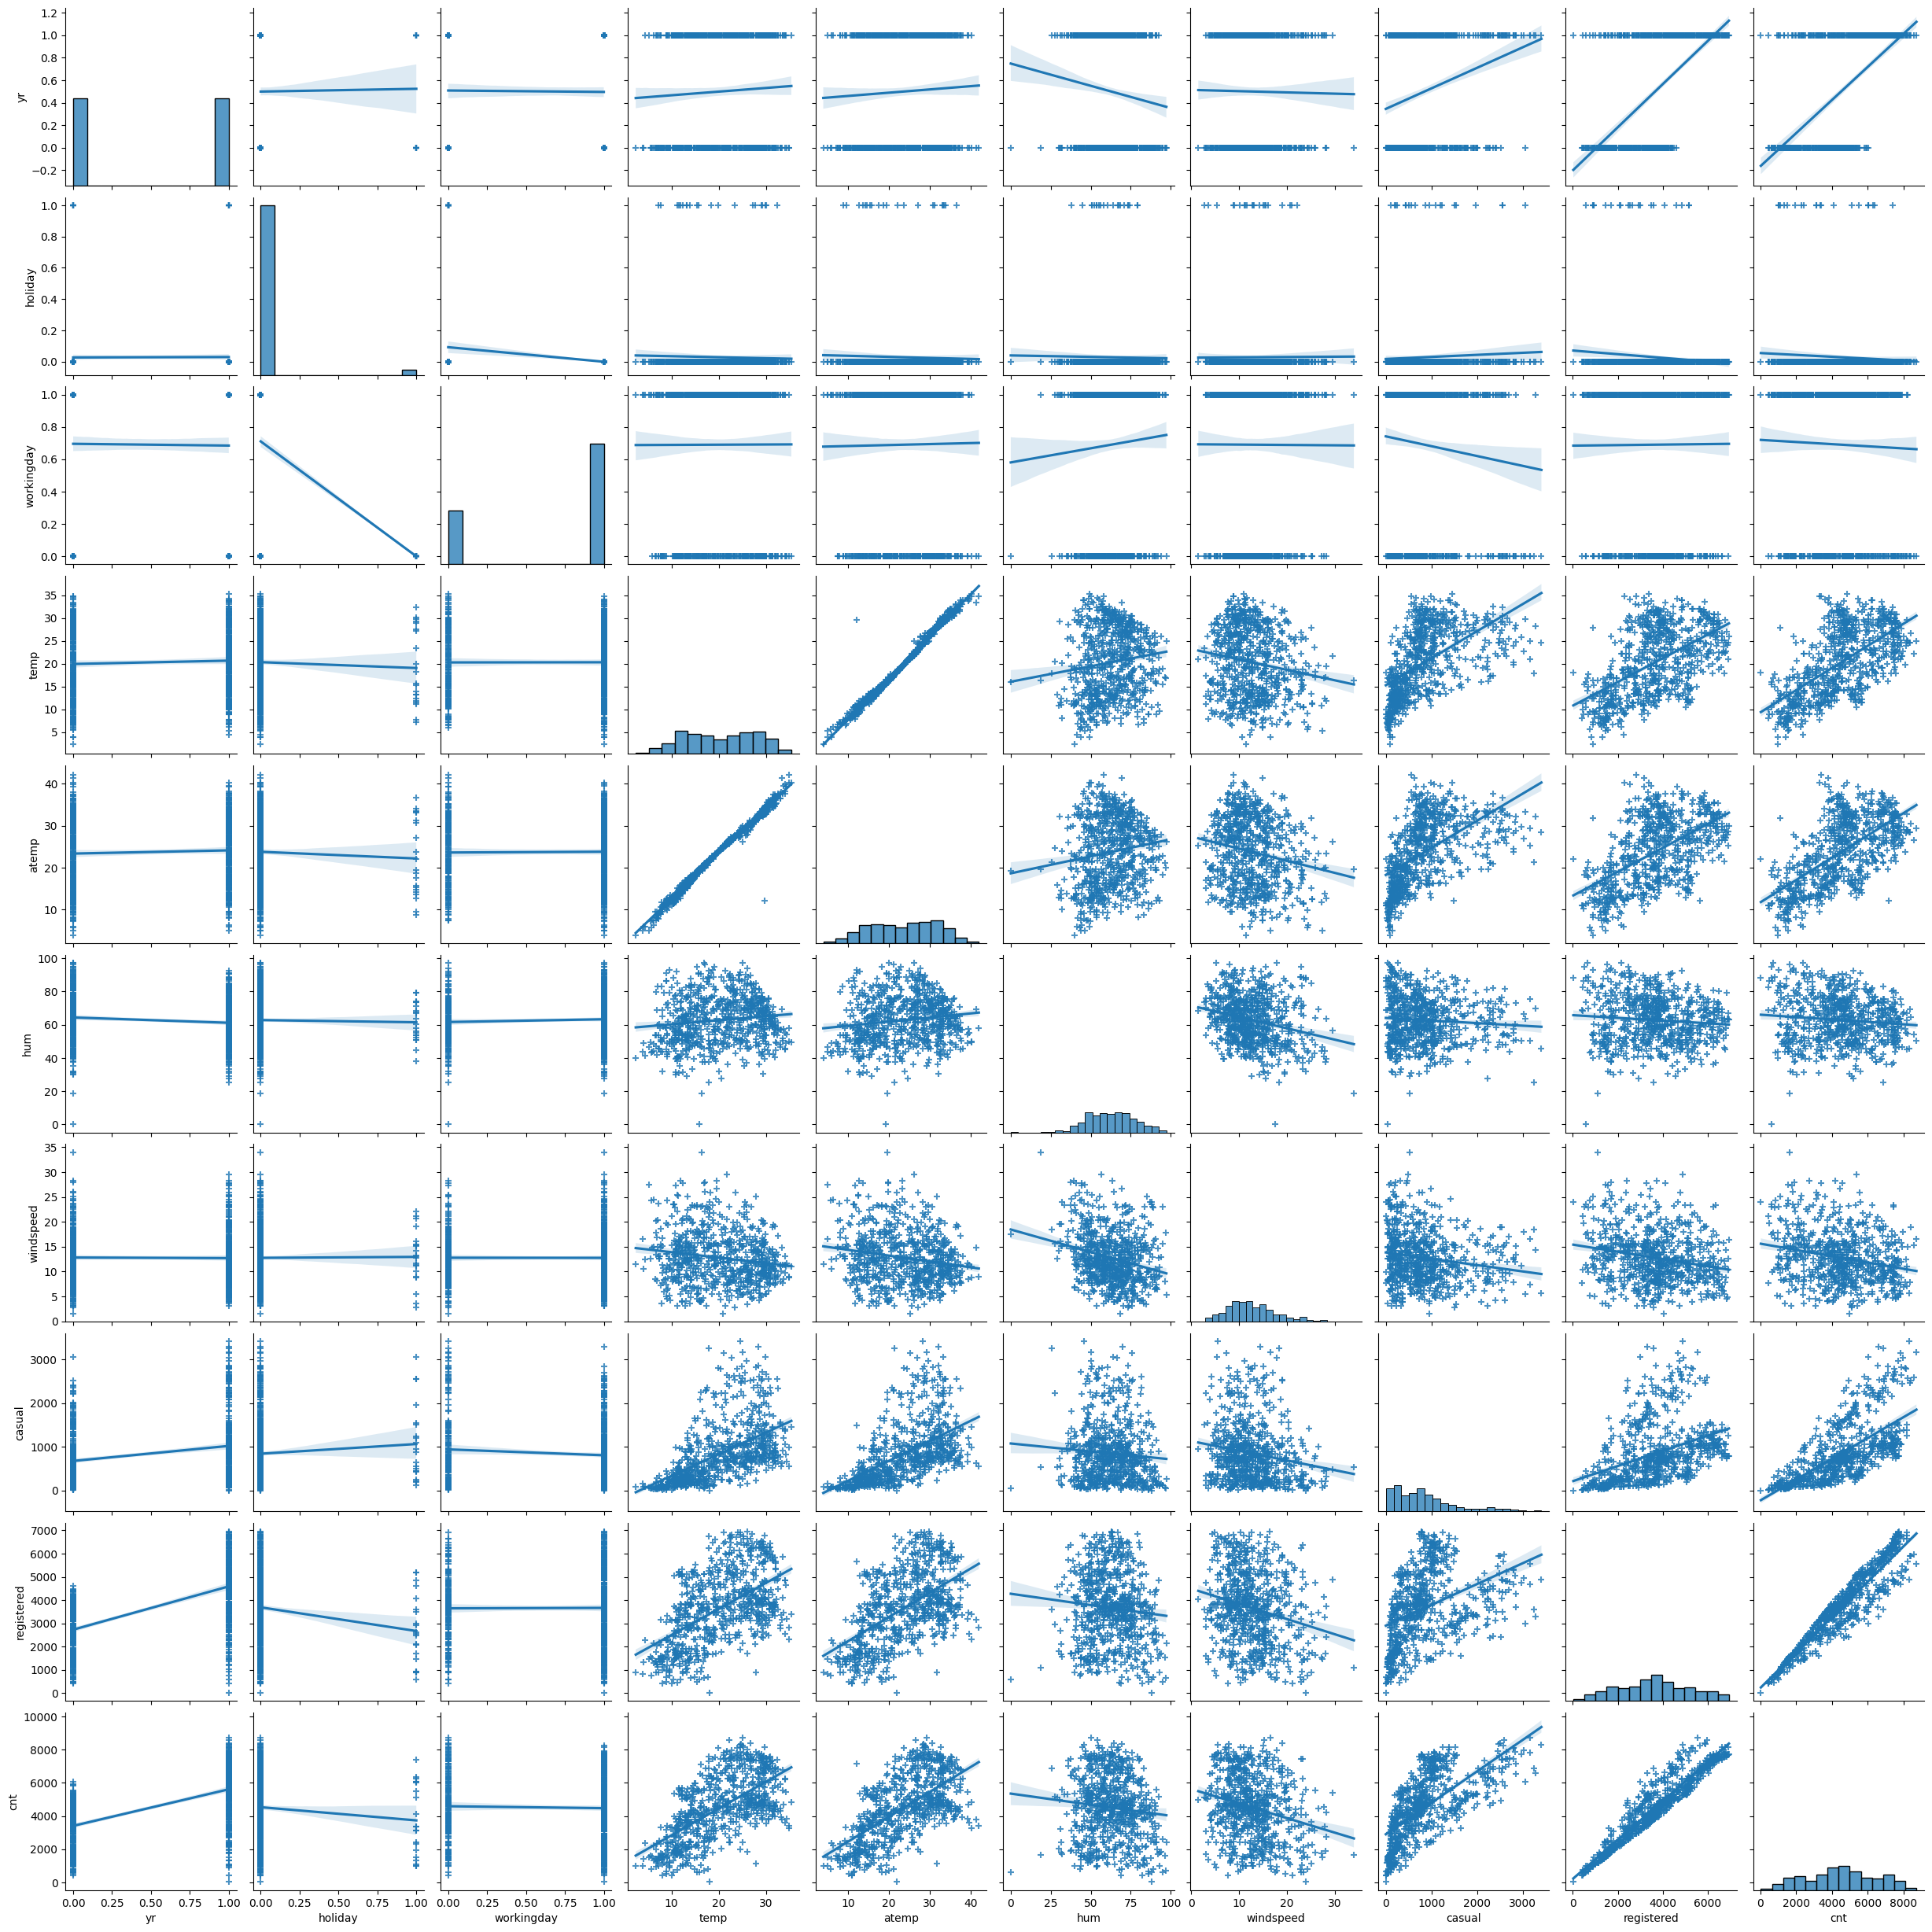

In [113]:

sns.pairplot(bike_df, kind= 'reg', markers= '+', palette= 'Purples')
plt.show()


<b>Observations: </b>
- Target Variable:
    - Direct proportionality with temp, atemp, casual and registered
    - Inverse proportionality with humidity and windspeed


- Independent Variables:
    - registered is directly proportional to temp, atemp, casual and inversely proportional with hum and windspeed
    - casual is directly proportional to temp, atemp, casual, registered and inversely proportional with hum and windspeed
    - windspeed is inversely proportional to temp, atemp and hum.
    - humidity is directly proportional to temp and atemp and inversely proportional to windspeed


<b>Note:</b>
- Our target 'cnt' is a summation of 'casual' and 'registered'
- Based on above logic, features 'casual' and 'registered' can completely explain the target variable
- <b>Hence, dropping casual and registered features</b>

In [114]:
bike_df.drop(labels= ['casual','registered'], axis= 1, inplace= True)


In [115]:

# Re-inspecting dataframe
bike_df.head(2)


season  yr mnth  holiday weekday  workingday        weathersit     temp  \
0  Spring   0  Jan        0     Mon           1  Misty and Cloudy 14.11085   
1  Spring   0  Jan        0     Tue           1  Misty and Cloudy 14.90260   

     atemp      hum  windspeed  cnt  
0 18.18125 80.58330   10.74988  985  
1 17.68695 69.60870   16.65211  801

- ### 2.3.2: Intervariable relationships using heatmap

In [116]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


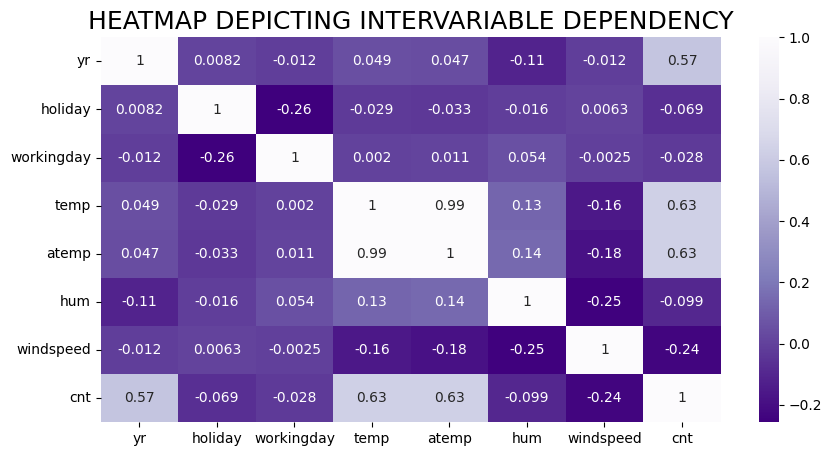

In [117]:
# Selecting only the numeric columns
numeric_df = bike_df.select_dtypes(include='number')

# Plotting Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(numeric_df.corr(), annot=True, cmap='Purples_r')

# Setting title
plt.title('HEATMAP DEPICTING INTERVARIABLE DEPENDENCY', fontsize=18, y=1)

plt.show()


<b>Observations:</b>
- Above heatmaps reconfirms our previous observations made from pairplot
- Extremely high correlation between atemp and temp observed.

- ## 2.4: Analysis of Growth Over Last Year (GOLY) of 2019

In [118]:

# Creating fresh dataframe showing monthly demand growth over last year
growth_pd= bike_df.pivot_table(index= 'mnth', columns= 'yr', values= 'cnt', aggfunc= 'mean')

# Amending column names
growth_pd.columns= ['2018', '2019']

# % growth column
growth_pd['percent growth']= round(((growth_pd['2019'] - growth_pd['2018'])/growth_pd['2018'])*100, 2)

# Sorting dataframe
growth_pd= growth_pd.sort_values(by= 'percent growth', ascending= False)

# Observing the final results
growth_pd


2018       2019  percent growth
mnth                                      
Mar  2065.96774 5318.54839       157.44000
Jan  1231.90323 3120.77419       153.33000
Feb  1721.96429 3617.96429       110.11000
Apr  3162.33333 5807.46667        83.64000
Sep  4247.26667 7285.76667        71.54000
Oct  3984.22581 6414.22581        60.99000
Aug  4409.38710 6919.45161        56.93000
Nov  3405.56667 5088.80000        49.43000
May  4381.32258 6318.22581        44.21000
Jul  4559.38710 6567.96774        44.05000
Dec  2816.87097 3990.74194        41.67000
Jun  4783.73333 6761.00000        41.33000

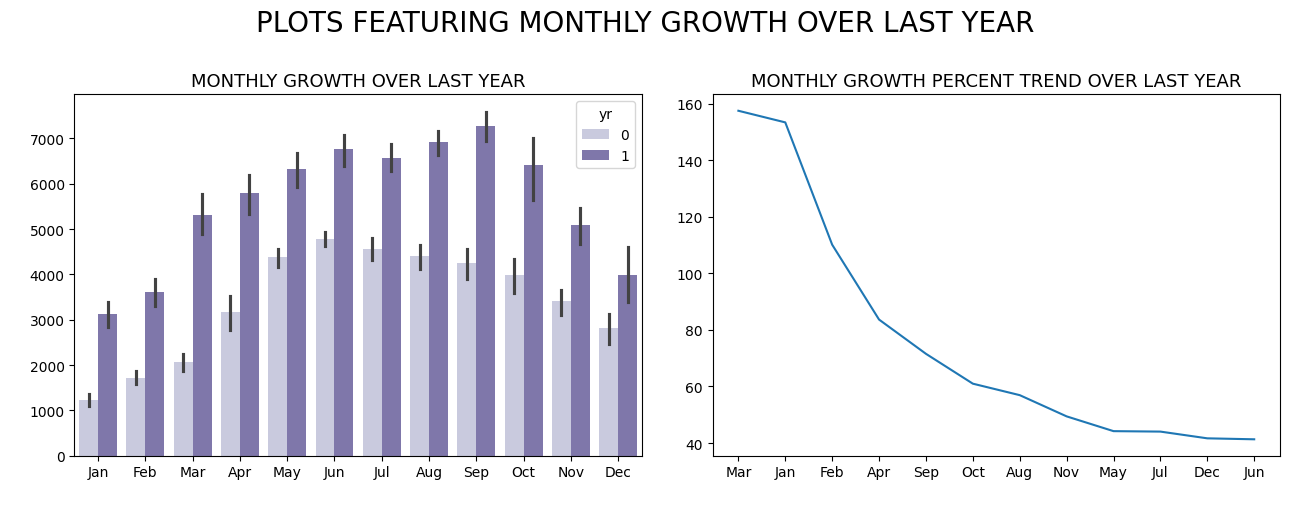

In [119]:
# Setting subplot grid
fig, ax= plt.subplots(nrows= 1, ncols= 2, figsize= (13, 5))

# Setting main title
plt.suptitle('plots featuring monthly Growth over last year'.upper(), fontsize= 20, y= 1.01)

# Populating plot 1
sns.barplot(x= 'mnth', y= 'cnt', data= bike_df, hue= 'yr', ax= ax[0], palette= 'Purples', )
ax[0].set_ylabel(' ')
ax[0].set_xlabel(' ')
ax[0].set_title('monthly growth over last year'.upper(), fontsize= 13)

# Populating plot 2
sns.lineplot(x= growth_pd.index, y= growth_pd['percent growth'], ax= ax[1], palette= 'Purples')
ax[1].set_ylabel(' ')
ax[1].set_xlabel(' ')
ax[1].set_title('monthly growth percent trend over last year'.upper(), fontsize= 13)

# Setting final aesthetics
plt.tight_layout()
plt.show()


<b>Observations:</b>
- Tremendous business growth shown in 2019 over 2018.
- 100+% growth observed in the months of Jan, Feb and March

# 3: Logic Note for further model development approach

<b>Machine Learning Problem </b>
- Relationship of target variable found with temp, atemp, humidity and windspeed in pairplots.
- Target variable found to be correlated with date, work_stat, season, month as depicted in earlier barplots.
- `Based on above, it is proven that this qualifies as a Machine Learning problem since the outcome depends on independent features and historical records`

<b>Supervised/ Unsupervised</b>
- We have target variable available with us and hence `it is a Supervised Learning problem.`

<b>Regression</b>
- Given target variable (cnt) is continuous and hence, `this problem qualifies to be a regression problem`

<b>Multiple Indpependent Features</b>
- From given EDA, we now kow that target variable is dependent on multiple features. Hence, `this problem qualifies to be a Multiple Linear Regression problem.`

# 4: Using Multiple Linear Regression for Model Development

In [120]:
# Re-Inspection of data

bike_df.head()


season  yr mnth  holiday weekday  workingday              weathersit  \
0  Spring   0  Jan        0     Mon           1        Misty and Cloudy   
1  Spring   0  Jan        0     Tue           1        Misty and Cloudy   
2  Spring   0  Jan        0     Wed           1  Clear to Partly Cloudy   
3  Spring   0  Jan        0     Thu           1  Clear to Partly Cloudy   
4  Spring   0  Jan        0     Fri           1  Clear to Partly Cloudy   

      temp    atemp      hum  windspeed   cnt  
0 14.11085 18.18125 80.58330   10.74988   985  
1 14.90260 17.68695 69.60870   16.65211   801  
2  8.05092  9.47025 43.72730   16.63670  1349  
3  8.20000 10.60610 59.04350   10.73983  1562  
4  9.30524 11.46350 43.69570   12.52230  1600

<b>Observations:</b>
- yr, holiday, workingday are binary variables

- ## 4.1: Creating Dummy Variables

In [121]:

# Creating new dataframe for ML algorithm (Deep copy of bike_df):
bike_df_ml= bike_df.copy()


In [122]:

# Creating a list of features that need to be converted to dummy variable:

dummy_list= [i for i in bike_df_ml.select_dtypes(include= 'object').columns]

# Creating dummies

for i in dummy_list:
    my_d= pd.get_dummies(data= bike_df_ml[i], drop_first= True)
    bike_df_ml= pd.concat([bike_df_ml, my_d], axis= 1).drop(labels= i, axis= 1)


# Re Inspecting Dataframe
bike_df_ml.head()


yr  holiday  workingday     temp    atemp      hum  windspeed   cnt  \
0   0        0           1 14.11085 18.18125 80.58330   10.74988   985   
1   0        0           1 14.90260 17.68695 69.60870   16.65211   801   
2   0        0           1  8.05092  9.47025 43.72730   16.63670  1349   
3   0        0           1  8.20000 10.60610 59.04350   10.73983  1562   
4   0        0           1  9.30524 11.46350 43.69570   12.52230  1600   

   Spring  Summer  ...    Oct    Sep    Mon    Sat    Sun    Thu    Tue  \
0    True   False  ...  False  False   True  False  False  False  False   
1    True   False  ...  False  False  False  False  False  False   True   
2    True   False  ...  False  False  False  False  False  False  False   
3    True   False  ...  False  False  False  False  False   True  False   
4    True   False  ...  False  False  False  False  False  False  False   

     Wed  Light Rain or Snow  Misty and Cloudy  
0  False               False              True  
1  False               False              True  
2   True               False             False  
3  False               False             False  
4  False               False             False  

[5 rows x 30 columns]

In [123]:
print(f'Our new dataset post dummy creation has {bike_df_ml.shape[0]} rows and {bike_df_ml.shape[1]} columns.')

Our new dataset post dummy creation has 730 rows and 30 columns.


- ## 4.2: Intervariable Interactions

- ### 4.2.1: Heatmap

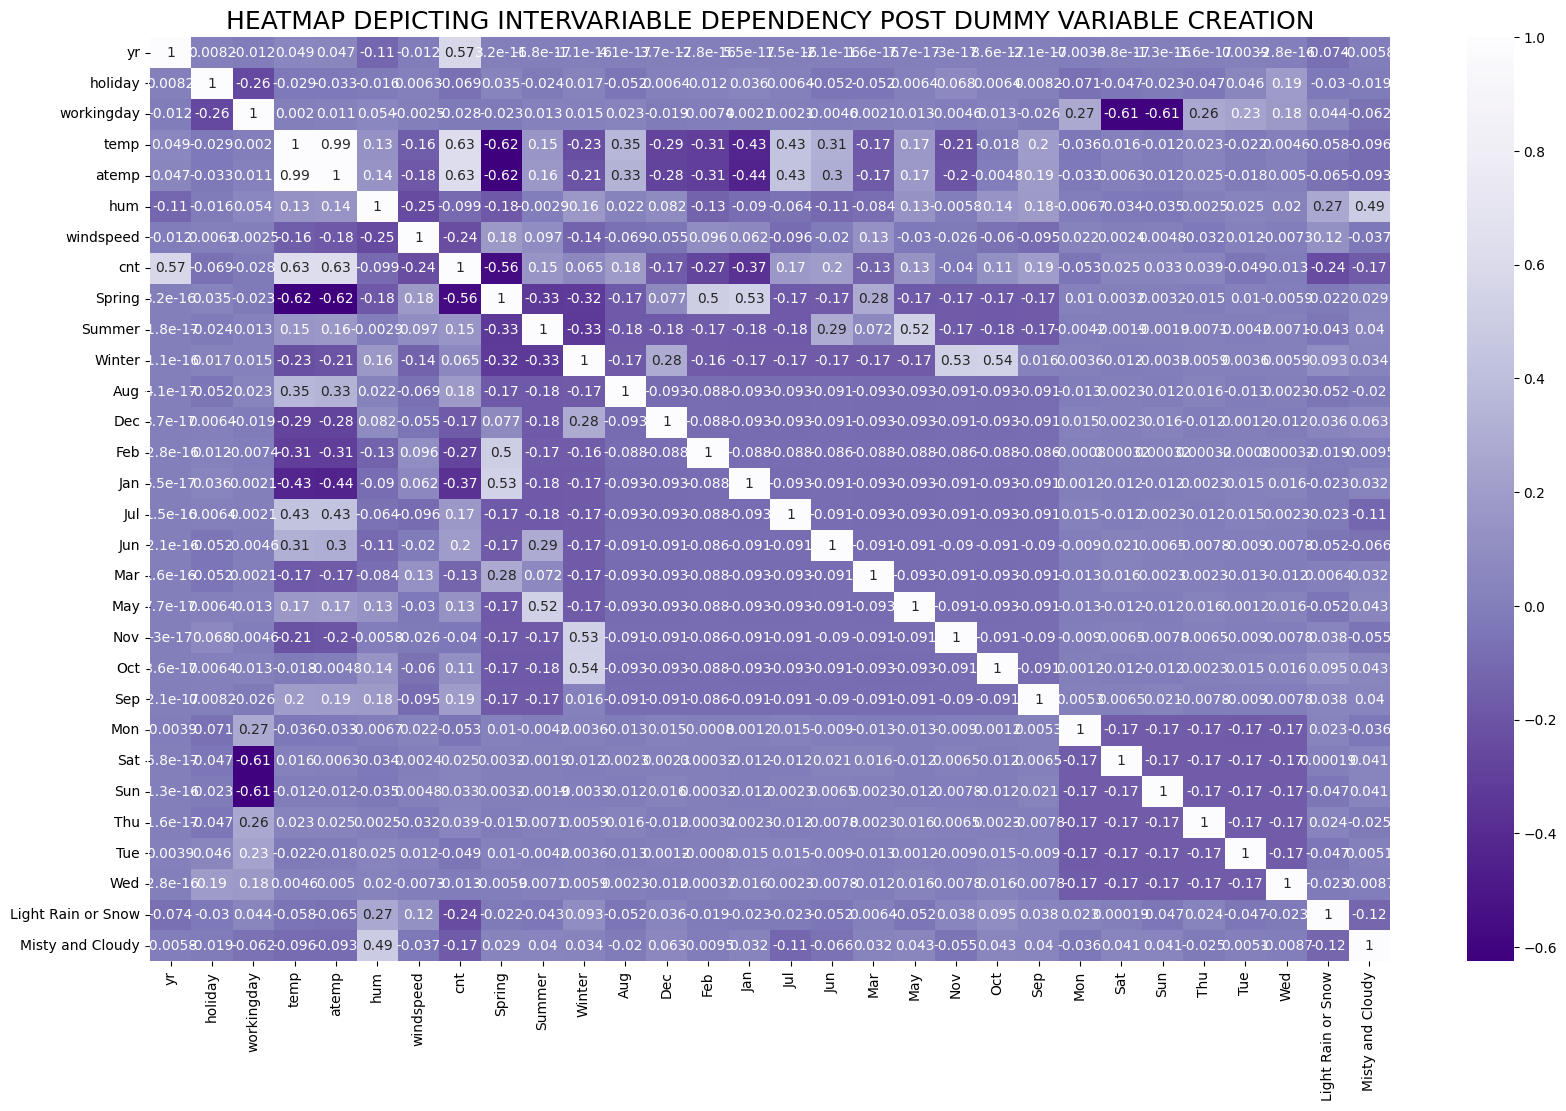

In [124]:

# Re-plotting heatmap

plt.figure(figsize=(20,12))
plt.title('heatmap depicting intervariable dependency post dummy variable creation'.upper(), fontsize= 18, y= 1)
sns.heatmap(bike_df_ml.corr(), annot= True, cmap= 'Purples_r', fmt= '.2g')
plt.show()


<b>Note:</b>
- Heatmap has become very dense due to high number of variables and limitation of display space.
- We will depict high level of positive and negative correlation in following dataframe.


- ### 4.2.2: Dataframe highlighting Intervariable Relationships

In [125]:

# Initiating variables:

col_list= []
ind_list= []
corr_type= []
corr_strength= []
corr_list= []

# Developing loop

for i in range(len(bike_df_ml.corr().columns)):
    for j in range(len(bike_df_ml.corr().index)):

        if bike_df_ml.corr().columns[i] != bike_df_ml.corr().index[j] and bike_df_ml.corr().iloc[i,j] != 0:

            if bike_df_ml.corr().iloc[i,j] < 0:

                if bike_df_ml.corr().iloc[i, j] <= -0.7:
                    col_list.append(bike_df_ml.corr().columns[i])
                    ind_list.append(bike_df_ml.corr().index[j])
                    corr_type.append('Negative')
                    corr_strength.append('Strong')
                    corr_list.append(round(bike_df_ml.corr().iloc[i,j], 2))

                elif bike_df_ml.corr().iloc[i,j] < -0.3:
                    col_list.append(bike_df_ml.corr().columns[i])
                    ind_list.append(bike_df_ml.corr().index[j])
                    corr_type.append('Negative')
                    corr_strength.append('Medium')
                    corr_list.append(round(bike_df_ml.corr().iloc[i,j], 2))


            else:

                if bike_df_ml.corr().iloc[i,j] >= 0.7:
                    col_list.append(bike_df_ml.corr().columns[i])
                    ind_list.append(bike_df_ml.corr().index[j])
                    corr_type.append('Positive')
                    corr_strength.append('Strong')
                    corr_list.append(round(bike_df_ml.corr().iloc[i,j], 2))

                elif bike_df_ml.corr().iloc[i,j] > 0.3:
                    col_list.append(bike_df_ml.corr().columns[i])
                    ind_list.append(bike_df_ml.corr().index[j])
                    corr_type.append('Positive')
                    corr_strength.append('Strong')
                    corr_list.append(round(bike_df_ml.corr().iloc[i,j], 2))


In [126]:

# New dataframe initialized to show intervariable relationships

boombike_corr_df= pd.DataFrame({'Column1': col_list, 'Column2': ind_list, 'Relationship Strength': corr_strength,
                                'Relation Type': corr_type, 'Correlation C': corr_list})

# Inspecting the dataframe
boombike_corr_df


Column1           Column2 Relationship Strength Relation Type  \
0                 yr               cnt                Strong      Positive   
1         workingday               Sat                Medium      Negative   
2         workingday               Sun                Medium      Negative   
3               temp             atemp                Strong      Positive   
4               temp               cnt                Strong      Positive   
5               temp            Spring                Medium      Negative   
6               temp               Aug                Strong      Positive   
7               temp               Feb                Medium      Negative   
8               temp               Jan                Medium      Negative   
9               temp               Jul                Strong      Positive   
10              temp               Jun                Strong      Positive   
11             atemp              temp                Strong      Positive   
12             atemp               cnt                Strong      Positive   
13             atemp            Spring                Medium      Negative   
14             atemp               Aug                Strong      Positive   
15             atemp               Feb                Medium      Negative   
16             atemp               Jan                Medium      Negative   
17             atemp               Jul                Strong      Positive   
18             atemp               Jun                Strong      Positive   
19               hum  Misty and Cloudy                Strong      Positive   
20               cnt                yr                Strong      Positive   
21               cnt              temp                Strong      Positive   
22               cnt             atemp                Strong      Positive   
23               cnt            Spring                Medium      Negative   
24               cnt               Jan                Medium      Negative   
25            Spring              temp                Medium      Negative   
26            Spring             atemp                Medium      Negative   
27            Spring               cnt                Medium      Negative   
28            Spring            Summer                Medium      Negative   
29            Spring            Winter                Medium      Negative   
30            Spring               Feb                Strong      Positive   
31            Spring               Jan                Strong      Positive   
32            Summer            Spring                Medium      Negative   
33            Summer            Winter                Medium      Negative   
34            Summer               May                Strong      Positive   
35            Winter            Spring                Medium      Negative   
36            Winter            Summer                Medium      Negative   
37            Winter               Nov                Strong      Positive   
38            Winter               Oct                Strong      Positive   
39               Aug              temp                Strong      Positive   
40               Aug             atemp                Strong      Positive   
41               Feb              temp                Medium      Negative   
42               Feb             atemp                Medium      Negative   
43               Feb            Spring                Strong      Positive   
44               Jan              temp                Medium      Negative   
45               Jan             atemp                Medium      Negative   
46               Jan               cnt                Medium      Negative   
47               Jan            Spring                Strong      Positive   
48               Jul              temp                Strong      Positive   
49               Jul             atemp                Strong      Positive   
50               Jun              t

<b>Observations:</b>
- Above table clearly shows the correlation where the variables are correlated.

<b>Notes:</b>
- The degree and strength of association was taken as:
    - If correlation between variable pairs is between 0.3 to 0.7: Medium Positive Correlation
    - If correlation between variable pairs is > 0.7: Strong Positive Correlation
    - If correlation between variable pairs is between -0.3 to -0.7: Medium Negative Correlation
    - If correlation between variable pairs is < -0.7: Strong Negative Correlation
        
These values were arrived at by referring online reources available on: https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/?__cf_chl_jschl_tk__=pmd_wj2BA1nh6BD0K5sdLDYWOQhA1XwO_iasaDKWlFjmP3U-1635681397-0-gqNtZGzNAnujcnBszQkR

In [127]:

# Displaying feature combinations of strong positive correlation
boombike_corr_df[(boombike_corr_df['Relationship Strength']== 'Strong')
                 & (boombike_corr_df['Relation Type']== 'Positive')].sort_values(by= 'Correlation C', ascending= False)


Column1           Column2 Relationship Strength Relation Type  \
11             atemp              temp                Strong      Positive   
3               temp             atemp                Strong      Positive   
21               cnt              temp                Strong      Positive   
4               temp               cnt                Strong      Positive   
12             atemp               cnt                Strong      Positive   
22               cnt             atemp                Strong      Positive   
0                 yr               cnt                Strong      Positive   
20               cnt                yr                Strong      Positive   
54               Oct            Winter                Strong      Positive   
38            Winter               Oct                Strong      Positive   
53               Nov            Winter                Strong      Positive   
47               Jan            Spring                Strong      Positive   
37            Winter               Nov                Strong      Positive   
31            Spring               Jan                Strong      Positive   
52               May            Summer                Strong      Positive   
34            Summer               May                Strong      Positive   
43               Feb            Spring                Strong      Positive   
30            Spring               Feb                Strong      Positive   
19               hum  Misty and Cloudy                Strong      Positive   
57  Misty and Cloudy               hum                Strong      Positive   
17             atemp               Jul                Strong      Positive   
48               Jul              temp                Strong      Positive   
49               Jul             atemp                Strong      Positive   
9               temp               Jul                Strong      Positive   
39               Aug              temp                Strong      Positive   
6               temp               Aug                Strong      Positive   
40               Aug             atemp                Strong      Positive   
14             atemp               Aug                Strong      Positive   
50               Jun              temp                Strong      Positive   
10              temp               Jun                Strong      Positive   
51               Jun             atemp                Strong      Positive   
18             atemp               Jun                Strong      Positive   

    Correlation C  
11        0.99000  
3         0.99000  
21        0.63000  
4         0.63000  
12        0.63000  
22        0.63000  
0         0.57000  
20        0.57000  
54        0.54000  
38        0.54000  
53        0.53000  
47        0.53000  
37        0.53000  
31        0.53000  
52        0.52000  
34        0.52000  
43        0.50000  
30        0.50000  
19        0.49000  
57        0.49000  
17        0.43000  
48        0.43000  
49        0.43000  
9         0.43000  
39        0.35000  
6         0.35000  
40        0.33000  
14        0.33000  
50        0.31000  
10        0.31000  
51        0.30000  
18        0.30000

<b>Observations:</b>
- Total 32 pairs found strong positive correlation.
- Since each pair is repeated twice, effectively we have 16 pairs of variables that shpw strong correlation

<b>Observations:</b>
- We dont have any variable pair that shows a Strong negative correlation.

- ## 4.2: Train Test Split

Dividing the data in 2 distinct datasets:
- bb_train: This dataset will be used in training the model to learn the coefficients
- bb_test: This dataset will largely remain "unknown" to our model and will be used in the end to test the the model propriety.

In [128]:
bike_df_ml.head()

yr  holiday  workingday     temp    atemp      hum  windspeed   cnt  \
0   0        0           1 14.11085 18.18125 80.58330   10.74988   985   
1   0        0           1 14.90260 17.68695 69.60870   16.65211   801   
2   0        0           1  8.05092  9.47025 43.72730   16.63670  1349   
3   0        0           1  8.20000 10.60610 59.04350   10.73983  1562   
4   0        0           1  9.30524 11.46350 43.69570   12.52230  1600   

   Spring  Summer  ...    Oct    Sep    Mon    Sat    Sun    Thu    Tue  \
0    True   False  ...  False  False   True  False  False  False  False   
1    True   False  ...  False  False  False  False  False  False   True   
2    True   False  ...  False  False  False  False  False  False  False   
3    True   False  ...  False  False  False  False  False   True  False   
4    True   False  ...  False  False  False  False  False  False  False   

     Wed  Light Rain or Snow  Misty and Cloudy  
0  False               False              True  
1  False               False              True  
2   True               False             False  
3  False               False             False  
4  False               False             False  

[5 rows x 30 columns]

In [129]:

# Initializing bb_train, bb_test:
bb_train, bb_test= train_test_split(bike_df_ml, test_size= 0.30, random_state= 100)


print(f'Training set: {bb_train.shape}')
print(f'Test set: {bb_test.shape}')


Training set: (511, 30)
Test set: (219, 30)


<b>Observations:</b>

- Adding the number of rows of train and test set comes to exactly 730 which matches the row count of our bike_df_ml dataset. Hence rows have been properly divided into test and train.
- Number of columns is 27 which matches the columns of our bike_df_ml dataset

In [130]:

# Visual inspection
bb_train.sample(5)


yr  holiday  workingday     temp    atemp      hum  windspeed   cnt  \
112   0        0           1 18.86000 22.50605 88.79170   15.45857  4036   
168   0        0           1 28.56335 32.19770 67.04170    8.00034  5119   
250   0        0           0 25.99043 27.76805 93.95650   12.91412  1842   
289   0        0           1 21.90085 25.53625 57.95830   11.75039  4570   
454   1        0           0 17.39085 21.08540 73.83330   16.79134  6235   

     Spring  Summer  ...    Oct    Sep    Mon    Sat    Sun    Thu    Tue  \
112   False    True  ...  False  False   True  False  False  False  False   
168   False    True  ...  False  False   True  False  False  False  False   
250   False   False  ...  False   True  False   True  False  False  False   
289   False   False  ...   True  False  False  False  False  False  False   
454   False    True  ...  False  False  False  False   True  False  False   

       Wed  Light Rain or Snow  Misty and Cloudy  
112  False               False              True  
168  False               False             False  
250  False                True             False  
289   True               False             False  
454  False               False              True  

[5 rows x 30 columns]

- ## 4.3: Rescaling of data

<b>Researcher had to chose from 2 of rescaling techniques:</b>
- Normalization: Also, called Min Max Scaling, it compresses the features in the range between 0 and 1.
- Standardization: It moves data on plot in such a way that mean becomes 0 and standard deviation becomes 1.

<b>In this case, researcher has decided to use MinMaxScaler because:</b>
- As shown in previous secion of EDA, some of the features contained outliers. We have not handled those outliers till now and MinMaxScaler will automatically handle them.
- Distribution does not matter in our dataset.
- Presence of binary variables which are already in 0 and 1 form. So rest of the data can be scaled accordingly.

MinMaxScaler uses Normalization formula of (X-Xmin)/(Xmax-Xmin) which basically translates the maximum data value as 1 and minimum data value as 0. Rest of the datapoints will remain between 1 and 0 based on relative context.

<b>Rescaling of data is done post the train_test_split because researcher does not want the scaler &/ or final model to know the test dataset.</b>

<b>Applying MinMaxScaler based on above logic on train data</b>

In [131]:

# Creating a scaler instance
scaler= MinMaxScaler()


In [132]:

# Initializing a list of feature names for scaling
scaler_list= [i for i in bb_train.columns if bb_train[i].nunique() > 2]

# Scaling the variables and saving in our dataframe:
bb_train[scaler_list]= scaler.fit_transform(bb_train[scaler_list])


In [133]:

# Inspecting bb_train:
bb_train.head()


yr  holiday  workingday    temp   atemp     hum  windspeed     cnt  \
653   1        0           1 0.50989 0.50113 0.57535    0.30079 0.86424   
576   1        0           1 0.81517 0.76635 0.72563    0.26469 0.82766   
426   1        0           0 0.44239 0.43897 0.64019    0.25534 0.46526   
728   1        0           1 0.24510 0.20035 0.49807    0.66311 0.20410   
482   1        0           0 0.39567 0.39174 0.50451    0.18847 0.48297   

     Spring  Summer  ...    Oct    Sep    Mon    Sat    Sun    Thu    Tue  \
653   False   False  ...   True  False  False  False  False  False  False   
576   False   False  ...  False  False  False  False  False  False  False   
426    True   False  ...  False  False  False  False   True  False  False   
728    True   False  ...  False  False   True  False  False  False  False   
482   False    True  ...  False  False  False  False   True  False  False   

       Wed  Light Rain or Snow  Misty and Cloudy  
653   True               False             False  
576   True               False             False  
426  False               False              True  
728  False               False             False  
482  False               False              True  

[5 rows x 30 columns]

- ## 4.4: Splitting Training Dataset in X & y

In [134]:

# Splitting in X and y

y_train= bb_train.pop('cnt')
X_train= bb_train


In [135]:

# Inspecting shapes of X_train and y_train
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')


X_train shape: (511, 29), y_train shape: (511,)


<b>Observations:</b>
- Data has been properly split in X_train & y_train with both having 511 rows, X_train having 26 columns and y_train having 1 column.

In [136]:

# Inspecting X_train:
X_train.head(2)


yr  holiday  workingday    temp   atemp     hum  windspeed  Spring  \
653   1        0           1 0.50989 0.50113 0.57535    0.30079   False   
576   1        0           1 0.81517 0.76635 0.72563    0.26469   False   

     Summer  Winter  ...    Oct    Sep    Mon    Sat    Sun    Thu    Tue  \
653   False    True  ...   True  False  False  False  False  False  False   
576   False   False  ...  False  False  False  False  False  False  False   

      Wed  Light Rain or Snow  Misty and Cloudy  
653  True               False             False  
576  True               False             False  

[2 rows x 29 columns]

In [137]:

# Inspecting y_train:
y_train.head(2)


653   0.86424
576   0.82766
Name: cnt, dtype: float64

- ## 4.5: Model Development

Researcher has decided to use combination of automated feature selection:
- <b>Automated Selection:</b>During the initial stage, researcher will use RFE (Recursive Feature Selection) for automated model selection. In line with industry practice, researcher will explicitly inform RFE function to halve the number of features of given dfataset based on their importance ranking.
- <b>Manual Selection: </b>Post automated approach, researcher will fine-tune the feature selection using manual approach based on knowledge gained from external desk research and intuition.

- ### 4.5.1: Recursive Feature Elimination (RFE)

In [138]:
lm = LinearRegression()

# Fitting model with X_train and y_train
lm.fit(X_train, y_train)

# Creating RFE instance
rfe = RFE(estimator=lm, n_features_to_select=15)

# Fitting the RFE instance
rfe = rfe.fit(X_train, y_train)

In [139]:

# Brief visual observation of results:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))


[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('temp', True, 1),
 ('atemp', False, 3),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Aug', False, 10),
 ('Dec', True, 1),
 ('Feb', False, 2),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 12),
 ('Mar', False, 15),
 ('May', False, 9),
 ('Nov', True, 1),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('Mon', False, 8),
 ('Sat', False, 5),
 ('Sun', False, 6),
 ('Thu', False, 14),
 ('Tue', False, 7),
 ('Wed', False, 11),
 ('Light Rain or Snow', True, 1),
 ('Misty and Cloudy', True, 1)]

<b>Observations:</b>
- Above results show the suggestions given by RFE function to retain top 15 features.
- Researcher arrived at 15 as retained features due to indutrial preferred practice of taking half the variables in account while operating RFE function.
- Wherever the boolean returnd by rfe.supprt_ is True, is the feature suggested by RFE to be included in the model.

<b>Using above results to extract 15 most index columns in train dataset</b>

In [140]:

# Initializing another dataframe
temp_rfe_df= pd.DataFrame()

# Adding names of features:
temp_rfe_df['Col']= X_train.columns

# Adding rfe.support_ to dataframe (Returns bool type value: True if feature is recommended to be kept and False otherwise)
temp_rfe_df['RFE_Support']= rfe.support_

# Retaining only the values that are recommended to be included in initial model
temp_rfe_df= temp_rfe_df[temp_rfe_df['RFE_Support']== True]

#Inspecting dataframe
temp_rfe_df


Col  RFE_Support
0                   yr         True
1              holiday         True
3                 temp         True
5                  hum         True
6            windspeed         True
7               Spring         True
8               Summer         True
9               Winter         True
11                 Dec         True
13                 Jan         True
14                 Jul         True
18                 Nov         True
20                 Sep         True
27  Light Rain or Snow         True
28    Misty and Cloudy         True

In [141]:

# Initializing a list of features that are to be included in initial model signalled by above dataframe
my_cols= [i for i in temp_rfe_df['Col']]

# Retaining features that are recommended in X_train
X_train[my_cols].head()


yr  holiday    temp     hum  windspeed  Spring  Summer  Winter    Dec  \
653   1        0 0.50989 0.57535    0.30079   False   False    True  False   
576   1        0 0.81517 0.72563    0.26469   False   False   False  False   
426   1        0 0.44239 0.64019    0.25534    True   False   False  False   
728   1        0 0.24510 0.49807    0.66311    True   False   False   True   
482   1        0 0.39567 0.50451    0.18847   False    True   False  False   

       Jan    Jul    Nov    Sep  Light Rain or Snow  Misty and Cloudy  
653  False  False  False  False               False             False  
576  False   True  False  False               False             False  
426  False  False  False  False               False              True  
728  False  False  False  False               False             False  
482  False  False  False  False               False              True

In [142]:
print(f'Final dataframe for model training has {X_train[my_cols].shape[0]} rows and {X_train[my_cols].shape[1]} columns.')

Final dataframe for model training has 511 rows and 15 columns.


- ### 4.5.2: Model Development

<b>During model development stage:</b>

<b>Variance Influence Factor:</b> Also known as VIF available in statsmodel library will be used to determine the variable that needs to be dropped to handle multicollinearity. `We will consider a threshold of 5 beyond which we will drop those variables (Unless any logic forces us to believe in keeping those particular variables in the dataset)`.

<b>Ordinary Least Squares:</b> We will use statsmodel to develop the Linear Regression model using OLS (Ordinary Least Squares) method. It is available in Statsmodel library and aims to minimize sum of residual squares to determine most ideal regression line. `We will consider a threshold of 0.05 p-value beyond which we will drop those variables one by one (Unless any logic forces us to believe in keeping those particular variables in the dataset)`.

<b>`During model development, we will start with all the variables in beginning calculating VIF for each of the variables and then building regression model using OLS. We will observe a combination of VIF values and p-values generated by the OLS model and drop the insignificant variables one by one. With each variable being dropped, an increase in R Squared is expected and p-values of leftover variables is expected to reduce and finally we will be left with all significant variables and a workable model.`</b>

- #### 4.5.2.1: Defining Functions

In [143]:

# Defining function for VIF table

def vif_table(dataframe):

    # Initialize a dataframe
    vif= pd.DataFrame()

    # Adding feature names
    vif['Feature']= dataframe.columns

    # Adding feature VIF values
    vif['VIF Value']= [round(variance_inflation_factor(dataframe.values, i), 2) for i in range(len(dataframe.columns))]

    # Sorting dataframe
    vif= vif.sort_values(by= 'VIF Value', ascending= False)

    # Output
    return vif


In [144]:

# Defining function for Regression Statistics

def regmodel_ols(y_dataframe, X_dataframe):
    X_dataframe = X_dataframe.astype(np.float64)
    y_dataframe = y_dataframe.astype(np.float64)

    # Adding constant - statsmodel needs a constant to be explicitly added
    X_dataframe= sm.add_constant(X_dataframe)

    # Creating Linear Regression instance based on OLS and fitting the data and creating summary
    lm= sm.OLS(y_dataframe, X_dataframe).fit()

    # Priting statistical summary
    print(lm.summary())


In [145]:

# Initializing dataframe:
X_train_1= X_train[my_cols]

X_train_1.astype(np.float64)

yr  holiday    temp     hum  windspeed  Spring  Summer  Winter  \
653 1.00000  0.00000 0.50989 0.57535    0.30079 0.00000 0.00000 1.00000   
576 1.00000  0.00000 0.81517 0.72563    0.26469 0.00000 0.00000 0.00000   
426 1.00000  0.00000 0.44239 0.64019    0.25534 1.00000 0.00000 0.00000   
728 1.00000  0.00000 0.24510 0.49807    0.66311 1.00000 0.00000 0.00000   
482 1.00000  0.00000 0.39567 0.50451    0.18847 0.00000 1.00000 0.00000   
..      ...      ...     ...     ...        ...     ...     ...     ...   
578 1.00000  0.00000 0.86397 0.67969    0.18714 0.00000 0.00000 0.00000   
53  0.00000  0.00000 0.20262 0.43594    0.11138 1.00000 0.00000 0.00000   
350 0.00000  0.00000 0.24822 0.57793    0.43182 0.00000 0.00000 1.00000   
79  0.00000  0.00000 0.46266 0.75987    0.52988 0.00000 1.00000 0.00000   
520 1.00000  0.00000 0.60023 0.63203    0.35960 0.00000 1.00000 0.00000   

        Dec     Jan     Jul     Nov     Sep  Light Rain or Snow  \
653 0.00000 0.00000 0.00000 0.00000 0.00000             0.00000   
576 0.00000 0.00000 1.00000 0.00000 0.00000             0.00000   
426 0.00000 0.00000 0.00000 0.00000 0.00000             0.00000   
728 1.00000 0.00000 0.00000 0.00000 0.00000             0.00000   
482 0.00000 0.00000 0.00000 0.00000 0.00000             0.00000   
..      ...     ...     ...     ...     ...                 ...   
578 0.00000 0.00000 0.00000 0.00000 0.00000             0.00000   
53  0.00000 0.00000 0.00000 0.00000 0.00000             0.00000   
350 1.00000 0.00000 0.00000 0.00000 0.00000             0.00000   
79  0.00000 0.00000 0.00000 0.00000 0.00000             0.00000   
520 0.00000 0.00000 0.00000 0.00000 0.00000             0.00000   

     Misty and Cloudy  
653           0.00000  
576           0.00000  
426           1.00000  
728           0.00000  
482           1.00000  
..                ...  
578           0.00000  
53            0.00000  
350           1.00000  
79            1.00000  
520           1.00000  

[511 rows x 15 columns]

- #### 4.5.2.2: Building Model

##### MODEL 1

In [146]:
# Building Regression Model
regmodel_ols(y_train, X_train_1)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     180.1
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          2.29e-189
Time:                        22:47:46   Log-Likelihood:                 514.84
No. Observations:                 511   AIC:                            -997.7
Df Residuals:                     495   BIC:                            -929.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3206      0

<b>Observations:</b>
- Above model shows R Squared value of 0.845 (84.5% variance in target variable is explained by the given 15 variables).
- Adjusted R Squared is 0.840
- P Value of all variables are within the acceptable threshold of 0.05 and hence dropping any variable will not be logical.
- It is important to keep the model simple and less complicated while maintaining efficacy and hence it is advisable to reduce the number of features (Currently 15).

In [147]:

# Inspecting VIF values:
vif_table(X_train_1.astype(np.float64))


Feature  VIF Value
3                  hum   30.93000
2                 temp   17.82000
4            windspeed    4.73000
5               Spring    4.37000
7               Winter    4.06000
6               Summer    2.82000
14    Misty and Cloudy    2.32000
0                   yr    2.09000
11                 Nov    1.83000
9                  Jan    1.75000
10                 Jul    1.59000
8                  Dec    1.55000
12                 Sep    1.41000
13  Light Rain or Snow    1.28000
1              holiday    1.06000

**Observations:**
- VIF of hum and temp is very high and not in acceptable limits.
- All our p-values are within the acceptable limits and hence, it is not possible to decide based on p-values which feature has to be dropped next.
- Both these variables are significant and their removal will affect the R Sqaured and adjusted R Squared values negatively. On doing hit and trial, researcher has found that dropping `hum` will lead to relatively lesser impact on R Squared and Adjusted R Squared values as compared to that of temp. Hence, we will drop `hum` before we redevelop the model.

##### MODEL 2

In [148]:
# Dropping 'temp' column:
X_train_2= X_train_1.drop(labels= 'hum', axis= 1)

# Rebuilding Model
regmodel_ols(y_train, X_train_2)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     185.1
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          1.41e-186
Time:                        22:47:46   Log-Likelihood:                 505.44
No. Observations:                 511   AIC:                            -980.9
Df Residuals:                     496   BIC:                            -917.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2457      0

**Observations:**
- R Squared and adjusted R Squared values have shown substantial decline, however, our VIF values are probably within limits making our model valid.
- Rechecking the VIF values

In [149]:
vif_table(X_train_2.astype(np.float64))

Feature  VIF Value
2                 temp    5.18000
3            windspeed    4.67000
6               Winter    2.94000
4               Spring    2.89000
5               Summer    2.24000
0                   yr    2.08000
10                 Nov    1.80000
8                  Jan    1.66000
9                  Jul    1.59000
13    Misty and Cloudy    1.56000
7                  Dec    1.46000
11                 Sep    1.35000
12  Light Rain or Snow    1.09000
1              holiday    1.06000

**Observations:**
- Value of `temp` is still beyond the acceptable limits to accept the model as valid. It shows high collinearity making model invalid.
- On closer inspection, researcher found that feature `Summer`, if dropped does not have a strong impact on our R Squared value whereas dropping temp will significantly affect our R Squared score.
- Dropping `Summer` feature

##### MODEL 3

In [150]:
# Dropping 'temp' column:
X_train_3= X_train_2.drop(labels= 'Summer', axis= 1)

# Rebuilding Model
regmodel_ols(y_train, X_train_3)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     197.4
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          1.15e-186
Time:                        22:47:46   Log-Likelihood:                 502.90
No. Observations:                 511   AIC:                            -977.8
Df Residuals:                     497   BIC:                            -918.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2902      0

**Observations:**
- Note the impact on R Squared and adjusted R Squared scores is minimal.
- Note that p value of feature 'Nov' is not within acceptable limits

In [151]:

# Re inspecting VIF values
vif_table(X_train_3.astype(np.float64))


Feature  VIF Value
2                 temp    4.68000
3            windspeed    4.05000
5               Winter    2.54000
4               Spring    2.36000
0                   yr    2.07000
9                  Nov    1.80000
7                  Jan    1.65000
12    Misty and Cloudy    1.53000
6                  Dec    1.46000
8                  Jul    1.36000
10                 Sep    1.21000
11  Light Rain or Snow    1.09000
1              holiday    1.06000

**Observations:**
- Note that all features are now within acceptable limits of VIF value.
- We will still have to drop `Nov` from our model because it's p-value is not in acceptable limits

##### MODEL 4

In [152]:

# Dropping 'temp' column:
X_train_4= X_train_3.drop(labels= 'Nov', axis= 1)

# Rebuilding Model
regmodel_ols(y_train, X_train_4)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     210.8
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          2.18e-186
Time:                        22:47:46   Log-Likelihood:                 499.46
No. Observations:                 511   AIC:                            -972.9
Df Residuals:                     498   BIC:                            -917.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2777      0

**Observations:**
- Note slight decrease in R Squared and adjusted R Squared values.
- None of the p-values are beyond the threshold of 0.05
- We still have 12 variables making it very complex. Hence, dropping the next best variable `Dec` for further fine tuning

In [153]:
# Re-Inspecting VIF values for final affirmation:
vif_table(X_train_4.astype(np.float64))


Feature  VIF Value
2                 temp    4.64000
3            windspeed    4.01000
4               Spring    2.36000
0                   yr    2.07000
5               Winter    1.64000
7                  Jan    1.64000
11    Misty and Cloudy    1.53000
8                  Jul    1.36000
6                  Dec    1.29000
9                  Sep    1.20000
10  Light Rain or Snow    1.08000
1              holiday    1.04000

**Observations:**
- All VIF values are within limits.
- Since the number of variables is high, we will drop the next best variable `Dec` to make the model simpler.

##### MODEL 5

In [154]:

# Dropping 'Dec' column:
X_train_5= X_train_4.drop(labels= 'Dec', axis= 1)

# Rebuilding Model
regmodel_ols(y_train, X_train_5)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     228.1
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          1.22e-186
Time:                        22:47:46   Log-Likelihood:                 497.23
No. Observations:                 511   AIC:                            -970.5
Df Residuals:                     499   BIC:                            -919.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2665      0

**Observations:**
- Note the impact on R Squared and adjusted R Squared as been extremely minute but the model has become slightly simpler with reduction of a variable
- Dropping `Jan` feature

In [155]:
# Re-Inspecting VIF values for final affirmation:
vif_table(X_train_5.astype(np.float64))

Feature  VIF Value
2                 temp    4.64000
3            windspeed    4.01000
4               Spring    2.24000
0                   yr    2.07000
6                  Jan    1.60000
10    Misty and Cloudy    1.53000
5               Winter    1.39000
7                  Jul    1.36000
8                  Sep    1.20000
9   Light Rain or Snow    1.08000
1              holiday    1.04000

**Observations:**

- All VIF values are within limits.
-Since the number of variables is high, we will drop the next best variable `Jan` to make the model simpler

##### MODEL 6

In [156]:
# Dropping 'Jan' column:
X_train_6= X_train_5.drop(labels= 'Jan', axis= 1)

# Rebuilding Model
regmodel_ols(y_train, X_train_6)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.0
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          1.28e-186
Time:                        22:47:46   Log-Likelihood:                 494.32
No. Observations:                 511   AIC:                            -966.6
Df Residuals:                     500   BIC:                            -920.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2526      0

**Observations:**
- Note slight impact on R Squared and Adjusted R Square but model has become simpler with 10 variables.

In [157]:

# Re-Inspecting VIF values for final affirmation:
vif_table(X_train_6.astype(np.float64))


Feature  VIF Value
2                temp    4.61000
3           windspeed    4.00000
0                  yr    2.06000
4              Spring    1.64000
9    Misty and Cloudy    1.52000
5              Winter    1.39000
6                 Jul    1.35000
7                 Sep    1.20000
8  Light Rain or Snow    1.08000
1             holiday    1.04000

**Observations:**
- All VIF Values are in proper limit thus fulfilling the `assumption of Multicollinearity` and making our model valid.

<b>As shown above, one of the assumptions of Liner Regression is satisfied:

- `None of the features in our model are related to one or combination of more then one features.`</b>


## 4.6: Residual Analysis

- ### 4.6.1: Normal Distribution of Errors

In [158]:
lm= sm.OLS(y_train.astype(np.float64), X_train_6.astype(np.float64)).fit()
ytrain_pred= lm.predict(X_train_6.astype(np.float64))
residuals= y_train-ytrain_pred

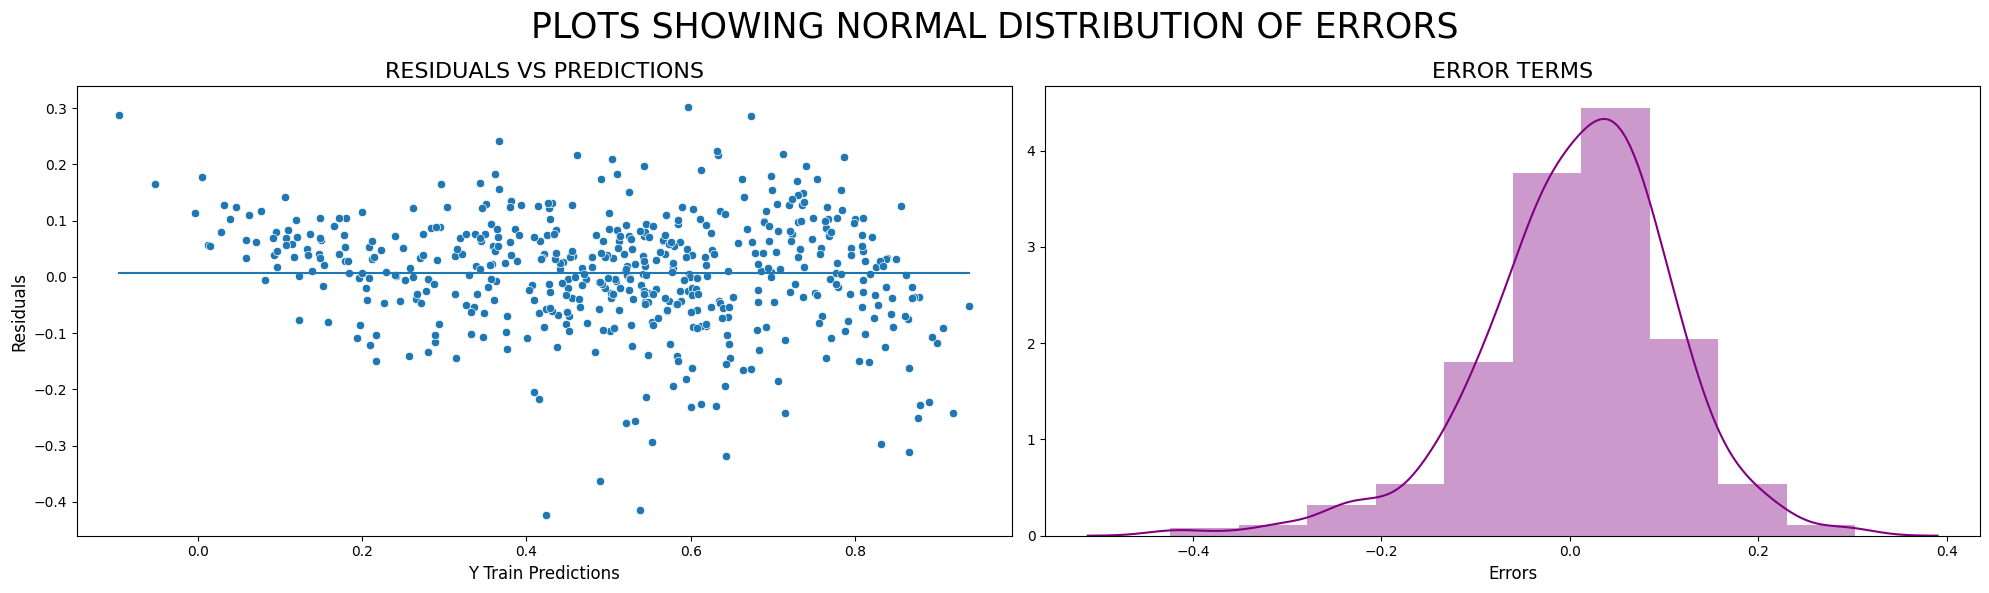

In [159]:
# Building subplots:
fig, ax= plt.subplots(nrows= 1, ncols= 2, figsize= (20, 6))

# Setting main title:
plt.suptitle('plots showing normal distribution of errors'.upper(), fontsize= 25)

# Populating first plot:
sns.scatterplot(y= residuals.values, x= ytrain_pred.values, palette= 'Purples', ax= ax[0])
sns.lineplot(y= residuals.mean(), x= ytrain_pred.values, palette= 'Purples', ax= ax[0])

# Title, ylabel and xlabel setting of first plot:
ax[0].set_title('residuals vs predictions'.upper(), fontsize= 16)
ax[0].set_ylabel('residuals'.title(), fontsize= 12)
ax[0].set_xlabel('y train predictions'.title(), fontsize= 12)

# Populating second plot:
sns.distplot(residuals, bins=10, color= 'Purple', ax= ax[1])

# Title, ylabel and xlabel setting of second plot:
ax[1].set_title('error terms'.upper(), fontsize= 16)
ax[1].set_ylabel('')
ax[1].set_xlabel('errors'.title(), fontsize= 12)

plt.tight_layout()
plt.show()


**Observations:**
- Mean of the residuals is extremely close to 0 `(Residual Mean: 0.00743)`
- For smaller values of predictions, the residuals are found to be on higher side and focussed above the mean value of 0. However, as we move further to larger predictions.
- This validates our assumption of normal distribution of errors around mean of 0

- ### 4.6.2: Testing for Homoscedasticity

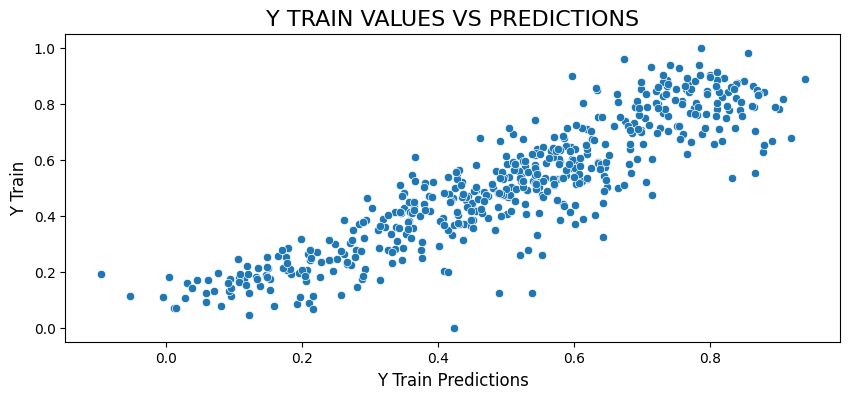

In [160]:

# Initiating a variable to save Series containing residuals
residuals= y_train-ytrain_pred

# Plotting residuals against predicted values

# Defining Figure Dimensions
plt.figure(figsize= (10,4))

# Plotting the residuals
sns.scatterplot(y= y_train, x= ytrain_pred, palette= 'Purples')

# Setting title, ylabel and xlabel
plt.title('y train values vs predictions'.upper(), fontsize= 16)
plt.ylabel('y train'.title(), fontsize= 12)
plt.xlabel('y train predictions'.title(), fontsize= 12)

plt.show()


**Observations:**
- The plot above shows an almost constant variance of predictions and thus the errors validating the assumption of Homoscedasticity.

- ### 4.6.3: Testing for correlation between Error Terms

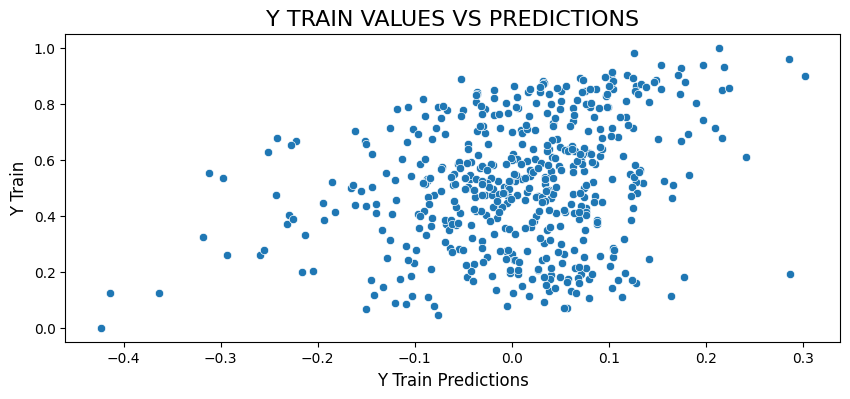

In [161]:

# Initiating a variable to save Series containing residuals
residuals= y_train-ytrain_pred

# Plotting residuals against predicted values

# Defining Figure Dimensions
plt.figure(figsize= (10,4))

# Plotting the residuals
sns.scatterplot(y= y_train, x= residuals, palette= 'Purples')

# Setting title, ylabel and xlabel
plt.title('y train values vs predictions'.upper(), fontsize= 16)
plt.ylabel('y train'.title(), fontsize= 12)
plt.xlabel('y train predictions'.title(), fontsize= 12)

plt.show()


- ## 4.7: Making Predictions

- ### 4.7.1: Applying Scaling on Test Dataset

Our scaler instance of MinMaxScaler is already initiated. We shall use the same scaler to rescale our test data variables. the scaled feature names are stored in the variable scaler_list from the rescaling activity of train set. We shall use the same to scale test data.

In [162]:

# Inspecting test data before scaling:
bb_test.sample(5)


yr  holiday  workingday     temp    atemp      hum  windspeed   cnt  \
457   1        0           1 19.13335 23.07415 39.66670    6.70891  6772   
109   0        0           1 24.39500 28.21960 61.41670   16.20897  3944   
654   1        0           1 18.68915 22.50540 69.29170    6.79186  7461   
723   1        1           0 11.94346 14.72325 73.47830   11.30464  1013   
562   1        0           1 33.55165 37.78415 50.58330    7.66674  6786   

     Spring  Summer  ...    Oct    Sep    Mon    Sat    Sun    Thu    Tue  \
457   False    True  ...  False  False  False  False  False  False  False   
109   False    True  ...  False  False  False  False  False  False  False   
654   False   False  ...   True  False  False  False  False   True  False   
723    True   False  ...  False  False  False  False  False  False  False   
562   False   False  ...  False  False  False  False  False  False  False   

       Wed  Light Rain or Snow  Misty and Cloudy  
457   True               False             False  
109  False               False             False  
654  False               False             False  
723   True               False              True  
562   True               False             False  

[5 rows x 30 columns]

In [163]:

# Scaling the variables and saving in our dataframe:
bb_test[scaler_list]= scaler.transform(bb_test[scaler_list])


**Note:**
- scaler is already fitted on the train data set, hence, in this step we did not use fit() or fit_transform() and used just transform() method.

In [164]:
# Inspecting test data post scaling:
bb_test.sample(5)

yr  holiday  workingday    temp   atemp     hum  windspeed     cnt  \
201   0        0           0 0.94185 0.98093 0.71232    0.38636 0.43281   
646   1        0           1 0.48289 0.47129 0.78489    0.31816 0.73286   
264   0        0           0 0.70925 0.62467 0.92958    0.18450 0.54913   
650   1        0           0 0.41643 0.40997 0.50966    0.22323 0.81535   
413   1        0           1 0.35828 0.36275 0.55088    0.31951 0.49425   

     Spring  Summer  ...    Oct    Sep    Mon    Sat    Sun    Thu    Tue  \
201   False   False  ...  False  False  False   True  False  False  False   
646   False   False  ...   True  False  False  False  False  False  False   
264   False   False  ...  False   True  False   True  False  False  False   
650   False   False  ...   True  False  False  False   True  False  False   
413    True   False  ...  False  False   True  False  False  False  False   

       Wed  Light Rain or Snow  Misty and Cloudy  
201  False               False              True  
646   True               False              True  
264  False               False              True  
650  False               False             False  
413  False               False             False  

[5 rows x 30 columns]

- ### 4.7.2: Partitioning the data into X_Test and y_Test

In [165]:

y_test= bb_test.pop('cnt')
X_test= bb_test


#Inspecting X_test
X_test.head()


yr  holiday  workingday    temp   atemp     hum  windspeed  Spring  \
184   0        1           0 0.83178 0.76966 0.65736    0.08422   False   
535   1        0           1 0.90135 0.84259 0.61013    0.15373   False   
299   0        0           0 0.51196 0.49615 0.83770    0.33421   False   
221   0        0           1 0.88163 0.79534 0.43710    0.33957   False   
152   0        0           0 0.81725 0.74147 0.31430    0.53741   False   

     Summer  Winter  ...    Oct    Sep    Mon    Sat    Sun    Thu    Tue  \
184   False   False  ...  False  False  False  False  False  False  False   
535    True   False  ...  False  False  False  False  False   True  False   
299   False    True  ...   True  False  False   True  False  False  False   
221   False   False  ...  False  False  False  False  False  False  False   
152    True   False  ...  False  False  False   True  False  False  False   

       Wed  Light Rain or Snow  Misty and Cloudy  
184   True               False              True  
535  False               False             False  
299  False               False              True  
221  False               False             False  
152  False               False             False  

[5 rows x 29 columns]

In [166]:
# Inspecting the test set shape:

print(f'X_test shape is: {X_test.shape}')
print(f'y_test shape is: {y_test.shape}')


X_test shape is: (219, 29)
y_test shape is: (219,)


- ### 4.7.3: Making Actual Predictions

In [167]:

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_6.columns]


# Making predictions
y_test_pred = lm.predict(X_test_new)


- ## 4.8: Evaluating the predictions

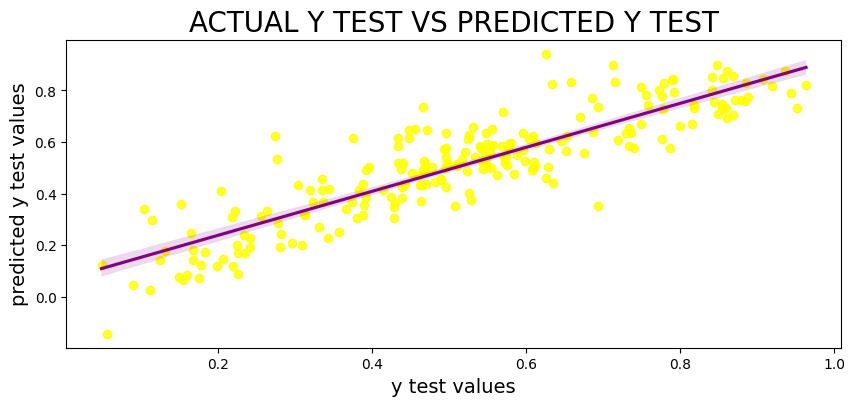

In [168]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure(figsize= (10, 4))

# Plotting figure
sns.regplot(x= y_test.astype(np.float64),y= y_test_pred.astype(np.float64), scatter_kws= {'color': 'yellow'}, line_kws= {'color': 'purple'})

# Setting title, X and Y labels
plt.title('actual y test vs predicted y test'.upper(), fontsize=20)
plt.xlabel('y test values', fontsize=14)
plt.ylabel('predicted y test values', fontsize=14)

plt.show()


**Observations:**
- Y Test values and Y Test predicted values have shown a strong visual semblence and hence our predicted are evaluated as a healthy fit. We do have presence of outliers, however, on a broader scale, most of the points display a healthy fit by following a trend.

- ## 4.9: Assessing the Model Quality And Generalization Ability

In [169]:
print('R2 score of test data predictions:', round(r2_score(y_pred= y_test_pred, y_true= y_test), 5))
print('R2 score of train data predictions:', round(r2_score(y_pred= ytrain_pred, y_true= y_train), 5))
print('Absolute difference between R2 scores of test and train dataset predictions:',
     abs(round(r2_score(y_pred= y_test_pred, y_true= y_test) - r2_score(y_pred= ytrain_pred, y_true= y_train), 5)))

R2 score of test data predictions: 0.77369
R2 score of train data predictions: 0.79497
Absolute difference between R2 scores of test and train dataset predictions: 0.02129


**`Since variation between train data prediction and test data prediction r2_score is less then 5%, model is proven to be dependable enough to be generalized.`**

- ## 4.10: Equation for prediction

In [170]:

# Initiating const variable for constant
const= 0.2526       # This information is taken from X_train_6 OLS model above

# Parameters Series:
parameter_series= pd.Series(lm.params)
print(parameter_series)


yr                    0.24236
holiday              -0.09353
temp                  0.73126
windspeed            -0.02337
Spring                0.00276
Winter                0.12793
Jul                  -0.10141
Sep                   0.05428
Light Rain or Snow   -0.27750
Misty and Cloudy     -0.05975
dtype: float64


In [171]:

# Equation:

print(f'Demand = {round(const, 3)}')
for i in range(len(parameter_series)):
    if i != len(parameter_series)-1:
        print(f'\t{parameter_series.index[i]} x {round(parameter_series.values[i], 3)} + ')
    else:
        print(f'\t{parameter_series.index[i]} x {round(parameter_series.values[i], 3)} ')


Demand = 0.253
	yr x 0.242 + 
	holiday x -0.094 + 
	temp x 0.731 + 
	windspeed x -0.023 + 
	Spring x 0.003 + 
	Winter x 0.128 + 
	Jul x -0.101 + 
	Sep x 0.054 + 
	Light Rain or Snow x -0.278 + 
	Misty and Cloudy x -0.06 


**Demand =** 0.253 + (***Year*** x 0.242) + (***Temperature*** x 0.731) + (***Spring*** x 0.003) + (***Winter*** x 0.128) + (***September*** x 0.054) - (***Light Rain or Snow*** x 0.278) - (***Misty and Cloudy*** x 0.06) - (***Holiday*** x 0.094) - (***July*** x 0.101) - (***Windspeed*** x 0.023)

**Notes:**
- Coefficients of `Year, Temperature, Spring, Winter and September` are positive.
- Coefficients of `Light Rain or snow, Misty and Cloudy, Holiday, July and Windspeed` are negative
- Constant is 0.253. That is, if all variables are kept as 0, the demand will be 0.253.

**Model Explanation:**
- If all variables are kept as 0, the demand will be 0.253.
- Following logical conclusions can be derived from above equation if all external and internal variables are stable:
    - If other features remain unchanged, with every change of year, demand is expected to increase 0.242 units.
    - If other features remain unchanged, demand is expected to increase by 0.003 units in the months corresponding to Spring season.
    - If other features remain unchanged, demand is expected to increase by 0.128 units in the months corresponding to Winter season.
    - If other features remain unchanged, demand is expected to increase by 0.054 units in September month.
    - If other features remain unchanged, demand is expected to decrease by 0.278 factors on the days of light rain &/ or snow.
    - If other features remain unchanged, demand is expected to decrease by 0.06 factors in Misty or Cloudy weather.
    - If other features remain unchanged, demand is expected to decrease by 0.094 factors on Holidays.
    - If other features remain unchanged, demand is expected to decrease by 0.101 factors in the month of July.
    - If other features remain unchanged, demand is expected to decrease by factor of 0.023  with every increase in the factor of rainfall measure.
    

In [172]:

# Defining a function to find top 'n' features
def nImportantFeatures(series, n):
    series= series.sort_values(key= lambda x: abs(x), ascending= False)
    return series.head(n)


In [173]:

# Identifying all features in decreasing order of importance/ relevance
descending_importance= nImportantFeatures(parameter_series, len(parameter_series))
descending_importance


temp                  0.73126
Light Rain or Snow   -0.27750
yr                    0.24236
Winter                0.12793
Jul                  -0.10141
holiday              -0.09353
Misty and Cloudy     -0.05975
Sep                   0.05428
windspeed            -0.02337
Spring                0.00276
dtype: float64

**:Plotting all features on decreasing order of magnitude of importance**

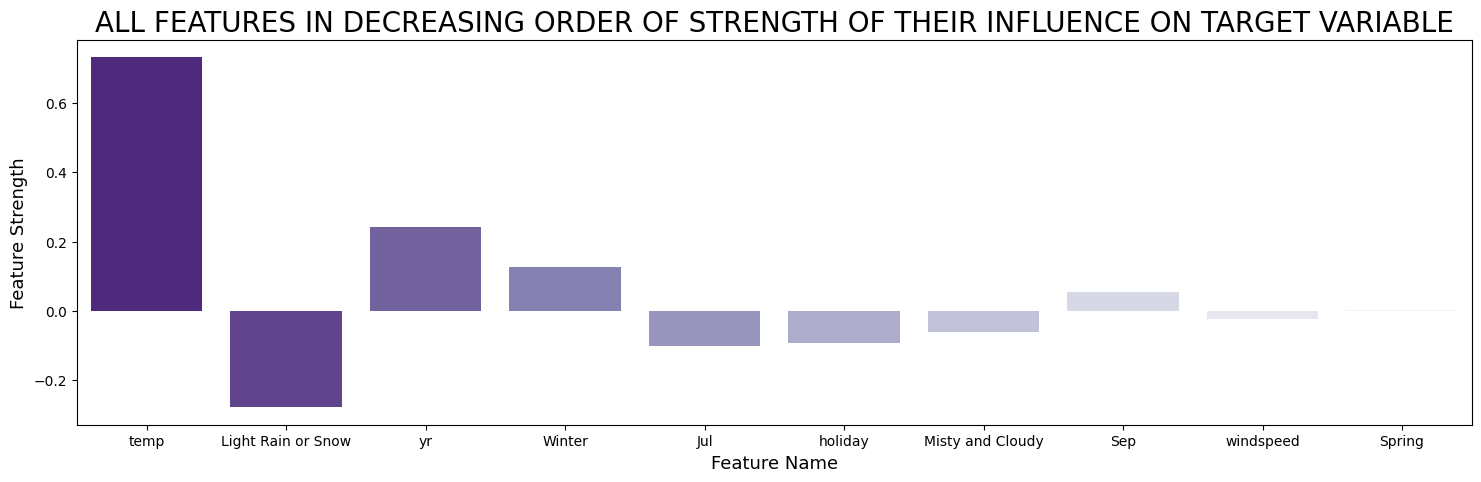

In [174]:

# Defining plot size
plt.figure(figsize= (18, 5))

# Plotting
sns.barplot(x= descending_importance.index, y= descending_importance.values, palette= 'Purples_r')

# Defining Plot Title, X Label and Y Label
plt.title('all features in decreasing order of strength of their influence on target variable'.upper(), fontsize= 20)
plt.xlabel('feature name'.title(), fontsize= 13)
plt.ylabel('feature strength'.title(), fontsize= 13)

plt.show()


# 5: Business Recommendations

**Given equation is too complex for business decision making. Hence, we will consider top 5 predictors to generate absolutely essential buisness recommendations and will be more practical in nature based on which business recommendation will be made**

In [175]:
# Identifying Top 5 predictors
top_5_features= nImportantFeatures(parameter_series, 5)
top_5_features


temp                  0.73126
Light Rain or Snow   -0.27750
yr                    0.24236
Winter                0.12793
Jul                  -0.10141
dtype: float64

**Plotting the top 5 features based on feature strength**

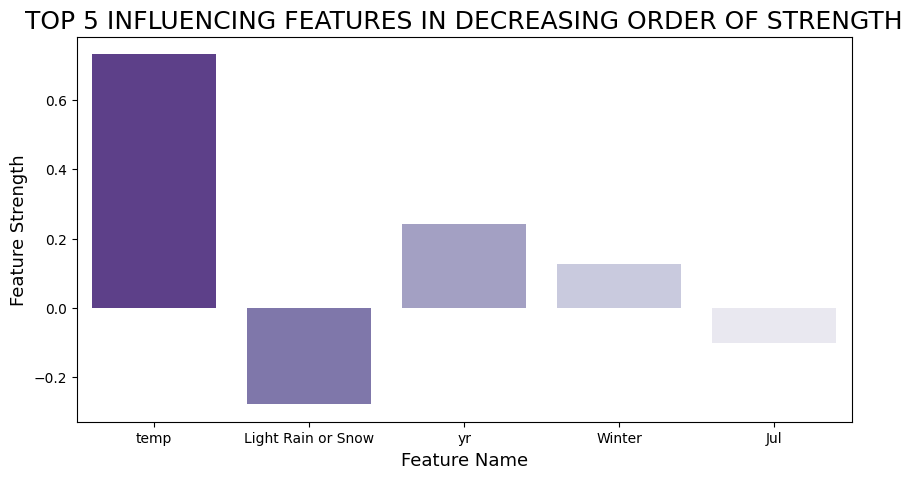

In [176]:
# Defining plot size
plt.figure(figsize= (10, 5))

# Plotting
sns.barplot(x= top_5_features.index, y= top_5_features.values, palette= 'Purples_r')

# Defining Plot Title, X Label and Y Label
plt.title('top 5 influencing features in decreasing order of strength'.upper(), fontsize= 18)
plt.xlabel('feature name'.title(), fontsize= 13)
plt.ylabel('feature strength'.title(), fontsize= 13)
plt.show()

## 5.1: Final Business Recommendations Based on Above

**Following logical conclusions can be derived from above equation if all external and internal variables are stable:**

- **Most important factor affecting demand is temperature. With a coefficient of 0.73126, for every change in temperature of 1 degrees, demand increases by a factor of 0.73126 (temperature x 0.73126). Based on this, company will have to consider:**
    - Necessary capacity building during hotter months to fulfill the demand:
        - Recall from our EDA section that hottest months lie in Fall season, June, July and Aug being the hottest.
    - If the company is able to scale up its resources to meet the increasing demand in these 3 months, it will also be wise to invest in increased marketing and promotional activities if more competitors operate in the same market with similar offering.
    
    
- **Second most important factor is Light Rain or Snow with a coefficient of -0.27750. Hence, if a particular day has light rains, it is expected to reduce the demand by 27.7%.**
    - Recall from our EDA section that frequency of light rains has been lowest and heavy rains have largely been non existant. October month shows the maximum number of instances of light rains.
        - Based on this, it is recommended to develop a sentiment based advertisement plan that heavily promotes "fun element" of "riding bikes in the rain with family".


- **Third most important factor is year with a coefficient value of 0.24236. Based on the historical data, given all internal and external factors remain unchanged, the company is expected to see annual growth over last year at around 24%.**
    - This helps us in factoring teh revenue and cost projections over a period of time.


- **Fourth most important factor is winter with a coefficient of 0.12793. Tihs signifies that every winter, the demand is expecteed to incerase by a factor of 0.12793 basd on other months.**
    - Recall from our EDA section, we recollect that Winter season constitutes of Sep, Oct, Nov and December months.
        - Company needs to work on capacity planing of these months and additionally plan for promotional campaigns in case a competitors exist with similar value propositions.
     
     
- **Fifth most important variable is the month of July with a coefficient weightage of -0.10141 which signifies that every July the demand is expected to drop by a factor of 0.10141 (Around 10%)**
    - Since month of July is also one of the hottest months, its relative weightage will simply decrease as compared to June and August. Hence, by logic, we can exclude month of July from our past recommendation.
